In [213]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import unittest
import doctest
import math

# Yield Functions

In [109]:
class YieldFunction():
    def __init__(self, name, mode, function, num_args, range): 
        self.name = name
        self.mode = mode
        # assumed now that the function can successfully be applied on numpy arrays. 
        # can modify code to be generalized to all types of functions
        self.function = function
        
        self.num_args = num_args
        self.range = range
    def return_yield(self, values): 
        
        if self.num_args == 1: 
            return self.function(values)
        elif self.num_args == 2: 
            # this assumes that the values are stored as a n by 2 numpy array 
            return self.function(values[:, 0], values[:, 1])
        else:
            raise AssertionError("return_yield, not yet implemented >2 dimensional")
    def plot_function(self):
        if self.num_args == 1:
            total_values = np.linspace(self.range[0], self.range[1])
            plt.scatter(total_values, self.return_yield(total_values))
            plt.title(f"Yield over range for {self.name}")
            plt.ylabel("Yields")
            plt.xlabel(f"{self.mode} values across range")

9


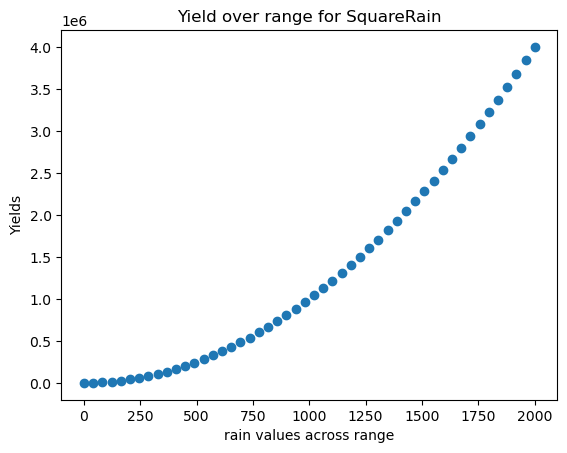

In [110]:
test = YieldFunction(name = "SquareRain", mode = "rain", function = np.square, num_args = 1, range = [1,2000])
print(test.return_yield(3))
test.plot_function()

In [68]:
# Great! Now we should define some yield functions that we can just use 
growing_rain_yield_functions = []
def flat_grow_rain(sum_rain):
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [600, 1000])
    # if sum_rain <= 800: 
    #     return 600
    # else:
    #     return 1000
def single_thresh_grow_rain(sum_rain):
    alpha = 0.5 
    # if sum_rain >= 800:
    #     return 1000
    # else:
    #     return 1000 - alpha * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1000 - alpha * (800 - x), 1000])
def double_kink_grow_rain(sum_rain):
    alpha = 0.5 
    beta = 1.0
    # if sum_rain >= 800:
    #     return 1000
    # elif sum_rain >= 650:
    #     return 1000 - alpha * (800 - sum_rain)
    # else: 
    #     return 1000 - beta * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain >= 800, sum_rain < 800, sum_rain < 650], [1000, lambda x: 800 - alpha * (800 - x), lambda x: 725 - beta * (650 - x)])

def quad_grow_rain(sum_rain):
    alpha = 0.00155
    beta = 800
    gamma = 1070
    return - (alpha * (sum_rain - beta)**2) + gamma
def abs_grow_rain(sum_rain):
    alpha = 0.75
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1125 - alpha * (800 - x), lambda x: 1125 + 0.60 * alpha * (800 - x)])


In [69]:
flat_rain = YieldFunction(name = "FlatRain", mode = "rain", function = flat_grow_rain, num_args = 1, range = [0,1500])
single_lin_rain = YieldFunction(name = "SingleLinRain", mode = "rain", function = single_thresh_grow_rain, num_args = 1, range = [0,1500])
double_lin_rain = YieldFunction(name = "DoubleLinRain", mode = "rain", function = double_kink_grow_rain, num_args = 1, range = [0,1500])
quad_rain = YieldFunction(name = "QuadRain", mode = "rain", function = quad_grow_rain, num_args = 1, range = [0,1500])
abs_rain = YieldFunction(name = "AbsRain", mode = "rain", function = abs_grow_rain, num_args = 1, range = [0,1500])
growing_rain_yield_functions.extend([flat_rain, single_lin_rain, double_lin_rain, quad_rain, abs_rain])

# Yield Simulator

In [70]:
# now we have 2 dimensional rain yield functions, let's build functionality for adding variability of some kind 
# for now, let's think of some statically bound variabilitiy (ie. variance is a constant value that we define)
# in this model, assume that actual yield = predicted yield + N(0, gamma), gamma is the variance value 
class YieldSimulator():
    def __init__(self, yield_function): 
        self.yield_function = yield_function
    def simulate(self, data, standard_dev = 1, rng = None):
        # data will come in a n by d format 
        # NEED TO MATCH THE DATA DIMENSIONS WITH THE YIELD FUNCTION DIMENSIONS
        predicted_yield = self.yield_function.return_yield(data)
        if rng == None:

            actual_yield = predicted_yield + np.random.normal(0, standard_dev, predicted_yield.shape)
        else:
            actual_yield = predicted_yield + rng.normal(0, standard_dev, predicted_yield.shape)

        return predicted_yield, actual_yield
    def plot_simulated_yield(self, data, standard_dev = 1): 
        pred, actual = self.simulate(data, standard_dev)
        plt.plot(actual)
        plt.title(f'Actual Yield with standard_dev = {standard_dev}')
        plt.plot(pred)
        plt.title(f"Predicted Yield with standard_dev = {standard_dev}")


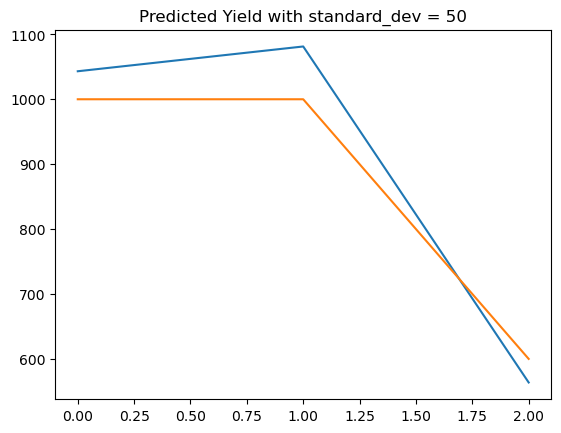

In [71]:
# testing that the yield simulator works
x = YieldSimulator(growing_rain_yield_functions[0])
x.simulate(np.array([[900],
                     [800],
                    [400]]), standard_dev = 50)
x.plot_simulated_yield(np.array([[900],
                     [800],
                    [400]]), standard_dev = 50)

# Rain Data

In [72]:
#data is in mm of rainfall
#goal is to create a montecarlo simulator of monthly rain in a chosen region 
#(let's choose Madhya Pradesh because supposedly it accounts for most of soybean production at 58% of total india)

url_1 = '../data/district_wise_rainfall_normal.csv'  # https://data.gov.in/catalog/rainfall-i
district_wise_dataset = pd.read_csv(url_1) 
url_2 = '../data/Sub_Division_IMD_2017'
subdiv_df = pd.read_csv(url_2)
district_name_mp = district_wise_dataset["STATE_UT_NAME"].unique()
district_name_mp.sort()
mp_string = district_name_mp[19]
district_wise_dataset.set_index(["STATE_UT_NAME", "DISTRICT"],inplace=True)
subdiv_df.set_index(['SUBDIVISION','YEAR'], inplace=True)
west_mp = subdiv_df.loc['West Madhya Pradesh']
east_mp = subdiv_df.loc['East Madhya Pradesh']
#cleaning nans
west_mp.isnull().values.any()
west_mp_annual = west_mp['ANNUAL']
east_mp_annual = east_mp['ANNUAL']
columns_to_drop = west_mp.columns[12:]
# prune extra columns
west_mp.drop(columns=columns_to_drop, inplace=True)
east_mp.drop(columns=columns_to_drop, inplace=True)
# 1901 to 2017 jan to dec columns
east_mp

/var/folders/hq/62b5kbn954ggcv_0g7_hdfmh0000gn/T/ipykernel_797/3785906917.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_mp.drop(columns=columns_to_drop, inplace=True)
/var/folders/hq/62b5kbn954ggcv_0g7_hdfmh0000gn/T/ipykernel_797/3785906917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  east_mp.drop(columns=columns_to_drop, inplace=True)


,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1901,48.5,38.1,15.7,10.7,6.2,61.0,367.5,589.2,189.9,5.9,0.0,0.0
1902,14.9,8.9,0.0,3.6,2.7,28.0,411.9,227.0,236.6,17.0,27.6,6.1
1903,5.6,2.9,0.3,0.9,37.5,67.5,261.4,366.7,257.4,177.9,0.0,0.0
1904,2.0,15.3,48.2,0.0,8.6,109.9,443.2,316.6,135.6,44.8,3.2,16.9
1905,15.9,8.0,14.3,12.3,10.2,34.4,292.4,243.3,250.9,2.9,0.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2013,2.0,43.4,14.1,9.5,0.3,311.9,456.2,480.8,78.0,124.2,0.5,1.0
2014,32.1,49.7,17.8,5.1,2.5,91.8,283.4,231.8,139.6,56.4,1.9,12.9
2015,37.3,11.0,73.4,25.8,6.3,139.2,262.2,272.1,71.6,38.2,1.2,0.9


In [73]:
# clean data and fill empty with 0 ## NOT SURE IF NEEDED
west_mp = west_mp.fillna(0)
west_mp.isnull().values.any()
east_mp = east_mp.fillna(0)
east_mp.isnull().values.any()
east_mp

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1901,48.5,38.1,15.7,10.7,6.2,61.0,367.5,589.2,189.9,5.9,0.0,0.0
1902,14.9,8.9,0.0,3.6,2.7,28.0,411.9,227.0,236.6,17.0,27.6,6.1
1903,5.6,2.9,0.3,0.9,37.5,67.5,261.4,366.7,257.4,177.9,0.0,0.0
1904,2.0,15.3,48.2,0.0,8.6,109.9,443.2,316.6,135.6,44.8,3.2,16.9
1905,15.9,8.0,14.3,12.3,10.2,34.4,292.4,243.3,250.9,2.9,0.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2013,2.0,43.4,14.1,9.5,0.3,311.9,456.2,480.8,78.0,124.2,0.5,1.0
2014,32.1,49.7,17.8,5.1,2.5,91.8,283.4,231.8,139.6,56.4,1.9,12.9
2015,37.3,11.0,73.4,25.8,6.3,139.2,262.2,272.1,71.6,38.2,1.2,0.9


In [74]:
# convert to numpy arrays 
east_mp.to_numpy().reshape(-1,1)
12 * len(east_mp) * 0.1
12 * len(east_mp) - (12 * len(east_mp) * 0.1)
west_mp.to_numpy().reshape(1,-1)[0]
len(east_mp.to_numpy().reshape(1,-1)[0]), len(west_mp.to_numpy().reshape(1,-1)[0])


(1404, 1404)

In [75]:
# create growing rain and harvest rain data. 
# Based on research papers on soybean farming in India, growing season refers to ~100 days during this time.
june = east_mp.to_numpy()[:, 5]
july = east_mp.to_numpy()[:, 6]
august = east_mp.to_numpy()[:, 7]
september = east_mp.to_numpy()[:, 8]
october = east_mp.to_numpy()[:, 9]
growing_rain_data = 0.5 * june + july + august + september
harvest_rain_data = october
growing_rain_data.shape, harvest_rain_data.shape

((117,), (117,))

Text(0.5, 1.0, 'Growing Rain data from 1900 to 2017 in eastern MP')

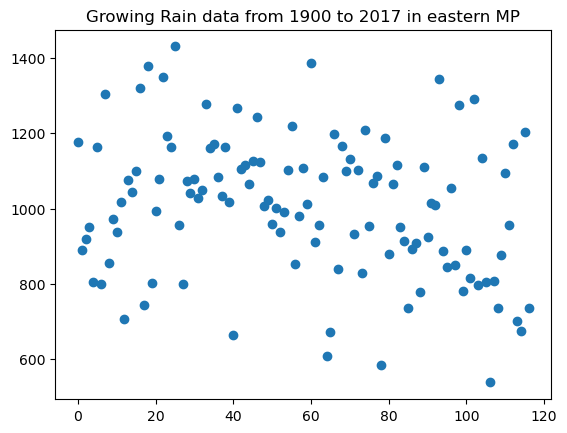

In [76]:
plt.scatter(np.arange(len(growing_rain_data)), growing_rain_data)
plt.title("Growing Rain data from 1900 to 2017 in eastern MP")

Text(0.5, 0, 'Growing Rain (mm)')

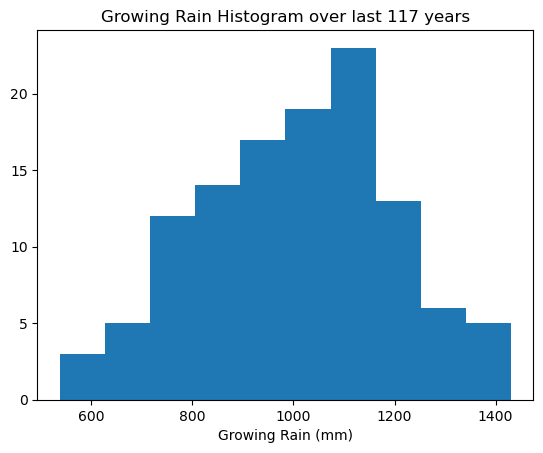

In [77]:
plt.hist(growing_rain_data, label = "growing rain (mm)")
plt.title("Growing Rain Histogram over last 117 years")

plt.xlabel("Growing Rain (mm)")

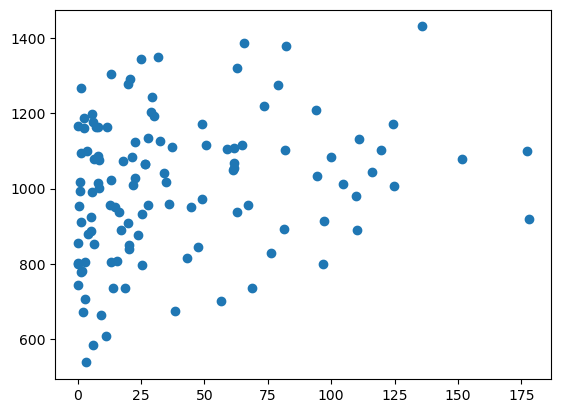

In [78]:
plt.scatter(harvest_rain_data, growing_rain_data)

In [79]:
# print means and standard deviations of growing rain and harvest rain data (focusing on growing rains for now)
g_mean, h_mean = np.mean(growing_rain_data), np.mean(harvest_rain_data)
g_std, h_std = np.std(growing_rain_data), np.std(harvest_rain_data)
print(g_mean, h_mean)
print(g_std)
print("2 standard deviations of growing rain mean:", str(g_mean + 2*g_std), str(g_mean - 2*g_std))

1004.8914529914529 39.41623931623931
184.9698283655503
2 standard deviations of growing rain mean: 1374.8311097225535 634.9517962603522


In [80]:
# sort the growing rain data. since we aren't using rain directly ## CAN LOOK AT THIS LATER AND CHANGE
sorted_growing_rain_data = np.array(sorted(growing_rain_data))
growing_rain_data, sorted_growing_rain_data

(array([1177.1 ,  889.5 ,  919.25,  950.35,  803.8 , 1164.35,  799.75,
        1303.85,  855.35,  971.75,  937.25, 1017.5 ,  707.7 , 1076.5 ,
        1043.4 , 1099.4 , 1320.5 ,  743.25, 1377.85,  802.7 ,  994.5 ,
        1077.65, 1350.  , 1191.35, 1162.55, 1430.45,  956.85,  799.45,
        1074.25, 1042.5 , 1078.3 , 1027.85, 1048.  , 1277.15, 1161.75,
        1170.75, 1083.05, 1033.95, 1164.  , 1018.6 ,  664.3 , 1267.1 ,
        1106.2 , 1115.25, 1065.75, 1125.7 , 1241.8 , 1124.4 , 1007.1 ,
        1021.45,  959.05, 1002.4 ,  938.45,  991.45, 1101.2 , 1219.35,
         853.45,  978.85, 1106.95, 1010.85, 1387.15,  910.15,  956.15,
        1084.85,  609.35,  671.75, 1198.95,  839.55, 1165.35, 1099.4 ,
        1131.7 ,  931.25, 1103.2 ,  827.6 , 1207.3 ,  953.05, 1066.5 ,
        1087.15,  584.45, 1188.65,  878.9 , 1066.25, 1116.15,  952.  ,
         912.75,  736.1 ,  892.7 ,  908.85,  777.05, 1109.3 ,  924.  ,
        1015.9 , 1009.7 , 1345.15,  886.4 ,  844.5 , 1053.55,  849.8 ,
      

(array([48., 25.,  9., 12.,  6.,  6.,  6.,  2.,  1.,  2.]),
 array([  0.  ,  17.79,  35.58,  53.37,  71.16,  88.95, 106.74, 124.53,
        142.32, 160.11, 177.9 ]),
 <BarContainer object of 10 artists>)

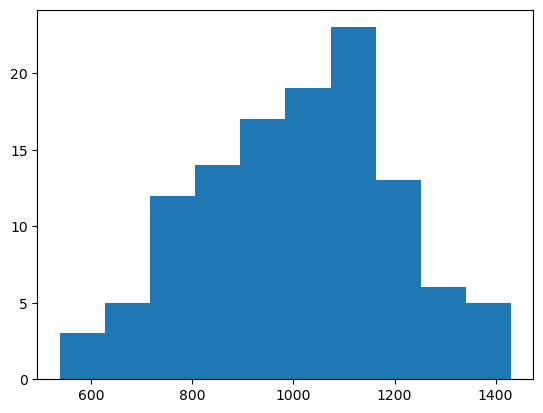

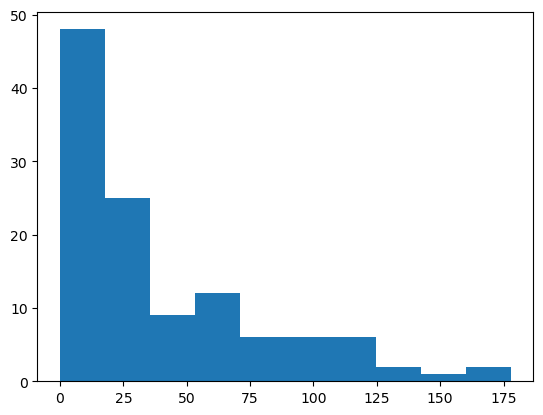

In [81]:
# histogram of growing rain data 
plt.hist(growing_rain_data)
plt.figure()
plt.hist(harvest_rain_data)


(array([4.8000e+01, 7.4400e+02, 5.2110e+03, 1.7991e+04, 3.1583e+04,
        2.8159e+04, 1.2890e+04, 3.0010e+03, 3.5600e+02, 1.7000e+01]),
 array([ 246.93139475,  403.70445753,  560.47752031,  717.25058309,
         874.02364587, 1030.79670865, 1187.56977144, 1344.34283422,
        1501.115897  , 1657.88895978, 1814.66202256]),
 <BarContainer object of 10 artists>)

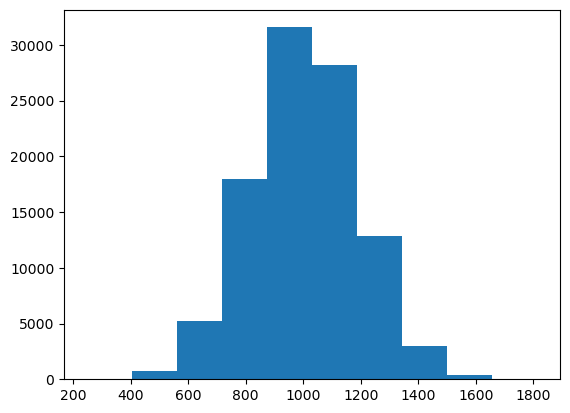

In [82]:
# how to generate m by n random normal samples from growing rain data 
grow_rain = np.random.normal(g_mean, g_std, size = (10000, 10)) # M by N matrix 
harvest_rain = np.random.normal(h_mean, h_std, size = (10, 10))
plt.hist(np.reshape(grow_rain, (-1, 1)))

# Test Rain to Yield with Abs Value Function


AbsRain
mean of growing rain data: 1004.8914529914529
std of growing rain data: 184.96982836555026
mean of yield: 1016.9639743589743
max of yield across data: 1124.8125
min of yield across data: 841.2975
std of yield: 66.97649203867752


(array([ 3.,  3.,  6.,  7., 15., 20., 18., 14., 15., 16.]),
 array([ 841.2975,  869.649 ,  898.0005,  926.352 ,  954.7035,  983.055 ,
        1011.4065, 1039.758 , 1068.1095, 1096.461 , 1124.8125]),
 <BarContainer object of 10 artists>)

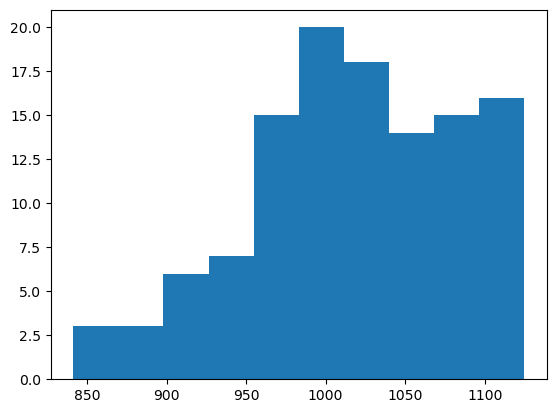

In [83]:
# testing the absolute value rain function
index = 4
yield_abs_emp_rain = []
rain_yield_func = growing_rain_yield_functions[index]
print(rain_yield_func.name)
for data_point in sorted_growing_rain_data:
    yield_abs_emp_rain.append(rain_yield_func.function(data_point))
print("mean of growing rain data: " + str(np.mean(sorted_growing_rain_data)))
print("std of growing rain data: " + str(np.std(sorted_growing_rain_data)))
print("mean of yield: " + str(np.mean(yield_abs_emp_rain)))
print("max of yield across data: " + str(np.max(yield_abs_emp_rain)))
print("min of yield across data: " + str(np.min(yield_abs_emp_rain)))
print("std of yield: " + str(np.std(yield_abs_emp_rain)))
plt.hist(yield_abs_emp_rain)

Text(0, 0.5, 'Yields (quintals per hectare)')

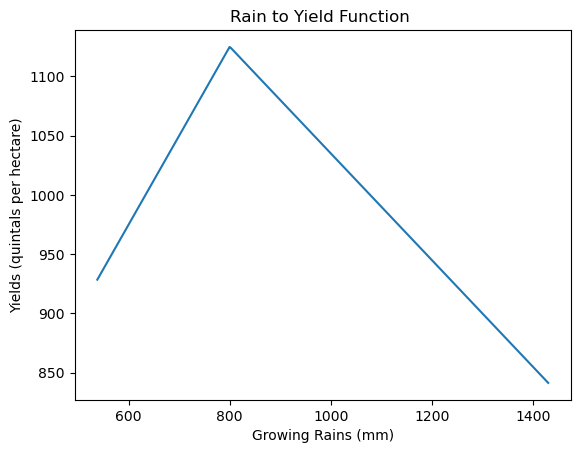

In [84]:
# plot yield over entire empirical
plt.plot(sorted_growing_rain_data, yield_abs_emp_rain)
plt.title("Rain to Yield Function ")
plt.xlabel("Growing Rains (mm)")
plt.ylabel("Yields (quintals per hectare)")



# Shortfall

In [85]:
import doctest

In [86]:
def shortfall(x, target): 
    '''
    This is a test: 
    >>> shortfall(10, 0)
    0
    '''
    return min(0, x - target)

In [87]:
import unittest
class testShortfall(unittest.TestCase):
    def runTest(self):
        x = 10
        target = -500 
        self.assertEqual(shortfall(x, target), 0, "incorrect shortfall")
    def test_shortfall_negative(self):
        x = -20
        target = -10
        expected = -10
        self.assertEqual(shortfall(x, target), expected, "shortfall fails on negatives")
    def test_shortfall_positive(self):
        x = 20
        target = -10
        expected = 0
        self.assertEqual(shortfall(x, target), expected, "shortfall fails on negatives")
    

In [88]:
res = unittest.main(argv=[''], verbosity=3, exit=False)
assert len(res.result.failures) == 0

test_shortfall_negative (__main__.testShortfall) ... ok
test_shortfall_positive (__main__.testShortfall) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


In [89]:
# doc tests
doctest.testmod()

TestResults(failed=0, attempted=1)

# Yield to Cash Function

In [90]:
# we need to develop the map from yield to cash
#data from marketing study done (2014 Solenkiatal)
# 2,195.00 2,258.00 2,290.00 2,241.00 in rupees per quintal received by the farmer
# but also 69,500.00 in returns, with costs of 32,071.44, so net income around 37,428.56
returns = 66080.00
yields = 20.65 
revenue_per_quintal = returns / yields
fixed_cost = 6251.75
variable_cost = 25711.87 - 901.43 # removed family cost as its not a direct cash cost
total_cost_per_hectare = fixed_cost + variable_cost
total_cost_per_hectare, revenue_per_quintal # 1 quintal = 100 kg of crops
def yield_to_cash_func(predicted_yield, rev_per_q = revenue_per_quintal, total_cost = total_cost_per_hectare): 
    return predicted_yield / 100 * revenue_per_quintal - total_cost

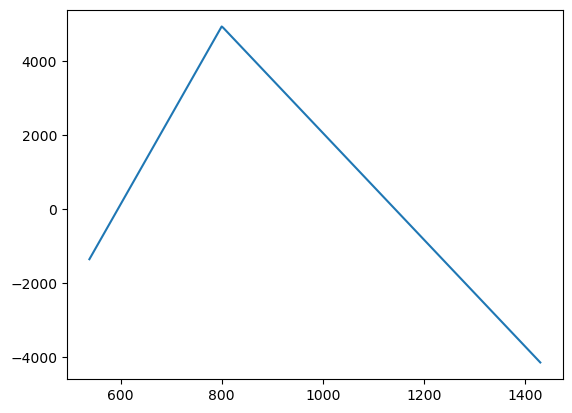

In [91]:
plt.plot(sorted_growing_rain_data, yield_to_cash_func(np.array(yield_abs_emp_rain)))

# Insurance Policy Creation


## Insurance Function Definition

In [92]:
# upper and lower, range in which if its not in range, it just doesn't get picked
def insurance_neg_yields(yield_func, lower_threshold, upper_threshold):
    def inner_function(x):
        final_output = []
        # ok there's definitely a better way to write this 

        if len(x.shape) == 1:
          for i in range(len(x)):
            if x[i] < lower_threshold or x[i] > upper_threshold:
                final_output.append(- yield_to_cash_func(yield_func.return_yield(x[i])))
            else: 
                final_output.append(0)
        elif len(x.shape) == 2:

        # there's probably a way to optimize this using np.piecewise but its buggy
          for i in range(len(x)):
              output = []
              for j in range(len(x[i])):
                if x[i][j] < lower_threshold or x[i][j] > upper_threshold:
                    output.append(- yield_to_cash_func(yield_func.return_yield(x[i][j])))
                else:
                  output.append(0)
              final_output.append(np.array(output))
        return np.array(final_output)
      #   
    return inner_function

In [93]:
# upper and lower, range in which if its not in range, it just doesn't get picked. 
# also, if the insurance policy would go negative, don't take away money and just make it 0 
def insurance_only_positive_yields(yield_func, lower_threshold, upper_threshold, lower_horizontal_shift, upper_horizontal_shift):
    def inner_function(x):
        final_output = []
        # ok there's definitely a better way to write this

        if len(x.shape) == 1:
          for i in range(len(x)):
            if x[i] < lower_threshold:
                output_append = - yield_to_cash_func(yield_func.return_yield(x[i])- lower_horizontal_shift)
                if output_append > 0:
                    final_output.append(output_append)
                else:
                    final_output.append(0)

            elif x[i] > upper_threshold:
                output_append = - yield_to_cash_func(yield_func.return_yield(x[i]  - upper_horizontal_shift))
                if output_append > 0:
                    final_output.append(output_append)
                else:
                    final_output.append(0)
            else: 
                final_output.append(0)
        elif len(x.shape) == 2:

        # there's probably a way to optimize this using np.piecewise but its buggy
          for i in range(len(x)):
              output = []
              for j in range(len(x[i])):
                if x[i][j] < lower_threshold or x[i][j] > upper_threshold:
                    output.append(- yield_to_cash_func(yield_func.return_yield(x[i][j]) - horizontal_shift))
                else:
                  output.append(0)
              final_output.append(np.array(output))
        return np.array(final_output)
    
    return inner_function

Text(0.5, 0, 'Rain values across range (mm)')

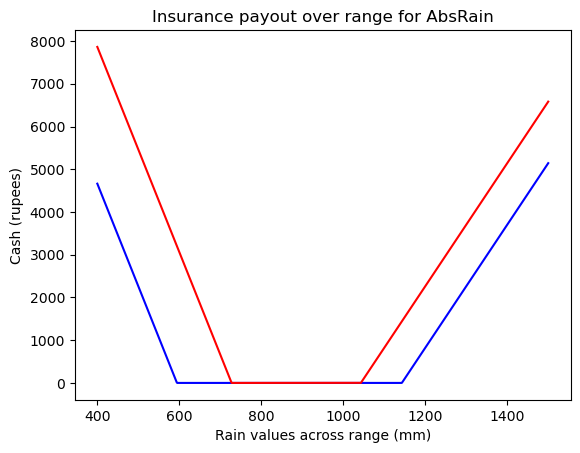

In [94]:
total_values = np.linspace(400, 1500, 1000)
#plt.plot(total_values, yield_to_cash_func(growing_rain_yield_functions[4].return_yield(total_values)))
plt.plot(total_values, insurance_only_positive_yields((growing_rain_yield_functions[4]), 800, 801, 0, 0)(total_values), color ='blue')
plt.plot(total_values, insurance_only_positive_yields((growing_rain_yield_functions[4]), 800, 801, 100, -100)(total_values), color = 'red')
#list_to_plot = yield_to_cash_func(growing_rain_yield_functions[4].return_yield(total_values)) + insurance_only_positive_yields(growing_rain_yield_functions[4], 600, 1000)(total_values)
#plt.plot(total_values, list_to_plot)

plt.title(f"Insurance payout over range for {growing_rain_yield_functions[4].name}")
plt.ylabel("Cash (rupees)")
plt.xlabel("Rain values across range (mm)")

## Insurance Premium Calculator


In [95]:
rain_to_insurance = insurance_only_positive_yields(growing_rain_yield_functions[4], 600, 1000, -100, 100)
# this calculator takes in an input the payout from insurance without the premiums
# finds the premium that should be given to maintain expected value = 0
def premium_calculator(rain_to_insurance, 
                                 n_trials = 100000, 
                                 mean = g_mean, 
                                 std = g_std, 
                                 seed=98765):
    # generate the rainfall
    rng = np.random.default_rng(seed)
    grow_rain = rng.normal(mean, std, size = (n_trials)) # M by N matrix 
    insurance_payout = rain_to_insurance(grow_rain)
    total_payout = np.sum(insurance_payout)
    
    num_payout = np.sum([1 if x > 0 else 0 for x in insurance_payout])
    percentage_payout = (float(num_payout)/ float((n_trials)))
    # expected value = 0 = n_trials * premium - total_payout 
    # -> total_payout / n_trials = premium
    premium = total_payout / n_trials
    return premium, total_payout, n_trials, percentage_payout
premium_calculator(rain_to_insurance)

(126.66049309479605, 12666049.309479605, 100000, 0.10128)

# Insurance Simulation - Random Sampling

In [96]:
def insurance_sim_rain_sample(n_trials, n_years, yield_simulator, insurance_policy, yield_variability, yield_to_cash = yield_to_cash_func, premium = 250, seed = 1234, target = 0, survival_target = 0):
    rng = np.random.default_rng(seed)
    print(f"Name of Yield Function: {yield_simulator.yield_function.name}")
    # print("Standard Deviation of Noise of Yield Prediction Function:", str(yield_variability), "\nTrials, Years: ", str(n_trials), ",", str(n_years))
    grow_rain = rng.normal(g_mean, g_std, size = (n_trials, n_years)) # M by N matrix 
    harvest_rain = rng.normal(h_mean, h_std, size = (n_trials, n_years))


    rain_trials = [] 
    pred_yield_trials = [] 
    actual_yield_trials = []
    no_policy_cash_trials = []
    with_policy_cash_trials = []
    insurance_payouts_trials = []
    
    

    policy_cash_matrix = []
    no_policy_cash_matrix = []

    policy_survivors_matrix = []
    no_policy_survivors_matrix = []

    policy_shortfalls_matrix = []
    no_policy_shortfalls_matrix = []
    
    for trial in range(n_trials):
        grow_rain_i = grow_rain[trial]
        harvest_rain_i = harvest_rain[trial]
        #data_i = np.c_[grow_rain_i, harvest_rain_i]
        data_i = grow_rain_i
        pred, actual = yield_simulator.simulate(data_i, standard_dev = yield_variability, rng = rng)
        insurance_payout_i = insurance_policy(data_i)
        yield_to_cash_i = yield_to_cash(actual)

        premium_payments = - premium * np.ones(n_years)
        rain_trials.append(data_i)
        pred_yield_trials.append(pred)
        actual_yield_trials.append(actual)
        no_policy_cash_trials.append(yield_to_cash_i)
        

        with_policy_cash_trials.append(insurance_payout_i + yield_to_cash_i + premium_payments)
        insurance_payouts_trials.append(insurance_payout_i + premium_payments)

        policy_cash_accumulated = 0
        policy_cash_years = []
        no_policy_cash_accumulated = 0
        no_policy_cash_years = []
        policy_survivors = n_trials
        no_policy_survivors = n_trials


        policy_shortfalls = []
        no_policy_shortfalls = []



        for year in range(n_years):
            
            policy_cash_accumulated += insurance_payout_i[year] + yield_to_cash_i[year] + premium_payments[year]
            policy_cash_years.append(policy_cash_accumulated)
            no_policy_cash_accumulated += yield_to_cash_i[year]
            no_policy_cash_years.append(no_policy_cash_accumulated)


            policy_shortfalls.append(shortfall(insurance_payout_i[year] + yield_to_cash_i[year] + premium_payments[year], target))
            no_policy_shortfalls.append(shortfall(yield_to_cash_i[year], target))

            


            if policy_cash_accumulated < survival_target: 
                policy_survivors -= 1
            if no_policy_cash_accumulated < survival_target: 
                no_policy_survivors -= 1
        policy_survivors_matrix.append(policy_survivors)
        no_policy_survivors_matrix.append(no_policy_survivors)
        policy_cash_matrix.append(policy_cash_years)
        no_policy_cash_matrix.append(no_policy_cash_years)    
        policy_shortfalls_matrix.append(policy_shortfalls)
        no_policy_shortfalls_matrix.append(no_policy_shortfalls)
    




    #print(np.mean(insurance_payouts_trials))
    #print(np.array(no_policy_shortfalls_matrix))
    # print(f"No policy cash (ie. cash from yields ONLY): {np.array(no_policy_cash_trials)}")
    # print(f"Insurance Payouts: {np.array(insurance_payouts_trials)}")
    # print(f"With policy cash (ie. cash from yield + insurance payouts + premium cost): {np.array(with_policy_cash_trials)}")
    return np.array(rain_trials), np.array(pred_yield_trials), np.array(actual_yield_trials), np.array(no_policy_cash_trials), np.array(with_policy_cash_trials), np.array(insurance_payouts_trials), np.array(policy_shortfalls), np.array(no_policy_shortfalls), np.array(policy_cash_matrix), np.array(no_policy_cash_matrix)



In [97]:
lower_threshold = 999
upper_threshold = 1000
lower_shift = 100
upper_shift = -100
rain_to_yield = growing_rain_yield_functions[4]
rain_to_insurance = insurance_only_positive_yields(rain_to_yield, lower_threshold, upper_threshold, lower_shift, upper_shift)
sim_out = insurance_sim_rain_sample(
            n_trials = 10, 
            n_years = 1, 
            yield_simulator = YieldSimulator(rain_to_yield),
            insurance_policy= rain_to_insurance,
            yield_variability= 1
)
print(sim_out[0])

Name of Yield Function: AbsRain
[[ 708.23003437]
 [1016.74800308]
 [1141.93398883]
 [1033.12139903]
 [1164.65801232]
 [1543.72691619]
 [ 731.35374979]
 [1179.77542684]
 [ 696.70666342]
 [1068.47382922]]


# Insurance Simulation with Empirical Rain Distribution

In [98]:
def insurance_sim_rain_empirical(n_trials,  yield_simulator, yield_to_cash, insurance_policy, yield_variability, premium = 250, seed = 1234, target = 0, survival_target = -5000):
    rng = np.random.default_rng(seed)
    print(f"Name of Yield Function: {yield_simulator.yield_function.name}")
    grow_rain = np.repeat(growing_rain_data[:, np.newaxis], n_trials, axis = 1).T
    #harvest_rain = np.random.normal(h_mean, h_std, size = (n_trials, n_years))
    n_years = len(grow_rain.T)
    

    rain_trials = [] 
    pred_yield_trials = [] 
    actual_yield_trials = []
    no_policy_cash_trials = []
    with_policy_cash_trials = []
    insurance_payouts_trials = []
    
    

    policy_cash_matrix = []
    no_policy_cash_matrix = []

    policy_survivors_matrix = []
    no_policy_survivors_matrix = []

    policy_shortfalls_matrix = []
    no_policy_shortfalls_matrix = []
    
    for trial in range(n_trials):
        grow_rain_i = grow_rain[trial]
        #harvest_rain_i = harvest_rain[trial]
        #data_i = np.c_[grow_rain_i, harvest_rain_i]
        data_i = grow_rain_i
        pred, actual = yield_simulator.simulate(data_i, standard_dev = yield_variability, rng = rng)
        insurance_payout_i = insurance_policy(data_i)
        yield_to_cash_i = yield_to_cash(actual)

        premium_payments = - premium * np.ones(n_years)
        rain_trials.append(data_i)
        pred_yield_trials.append(pred)
        actual_yield_trials.append(actual)
        no_policy_cash_trials.append(yield_to_cash_i)
        

        with_policy_cash_trials.append(insurance_payout_i + yield_to_cash_i + premium_payments)
        insurance_payouts_trials.append(insurance_payout_i + premium_payments)

        policy_cash_accumulated = 0
        policy_cash_years = []
        no_policy_cash_accumulated = 0
        no_policy_cash_years = []
        policy_survivors = n_trials
        no_policy_survivors = n_trials


        policy_shortfalls = []
        no_policy_shortfalls = []



        for year in range(n_years):
            
            policy_cash_accumulated += insurance_payout_i[year] + yield_to_cash_i[year] + premium_payments[year]
            policy_cash_years.append(policy_cash_accumulated)
            no_policy_cash_accumulated += yield_to_cash_i[year]
            no_policy_cash_years.append(no_policy_cash_accumulated)


            policy_shortfalls.append(shortfall(insurance_payout_i[year] + yield_to_cash_i[year] + premium_payments[year], target))
            no_policy_shortfalls.append(shortfall(yield_to_cash_i[year], target))

            


            if policy_cash_accumulated < survival_target: 
                policy_survivors -= 1
            if no_policy_cash_accumulated < survival_target: 
                no_policy_survivors -= 1
        policy_survivors_matrix.append(policy_survivors)
        no_policy_survivors_matrix.append(no_policy_survivors)
        policy_cash_matrix.append(policy_cash_years)
        no_policy_cash_matrix.append(no_policy_cash_years)    
        policy_shortfalls_matrix.append(policy_shortfalls)
        no_policy_shortfalls_matrix.append(no_policy_shortfalls)
    




    #print(np.mean(insurance_payouts_trials))
    #print(np.array(no_policy_shortfalls_matrix))
    # print(f"No policy cash (ie. cash from yields ONLY): {np.array(no_policy_cash_trials)}")
    # print(f"Insurance Payouts: {np.array(insurance_payouts_trials)}")
    # print(f"With policy cash (ie. cash from yield + insurance payouts + premium cost): {np.array(with_policy_cash_trials)}")
    return np.array(rain_trials), np.array(pred_yield_trials), np.array(actual_yield_trials), np.array(no_policy_cash_trials), np.array(with_policy_cash_trials), np.array(insurance_payouts_trials), np.array(policy_shortfalls), np.array(no_policy_shortfalls), np.array(policy_cash_matrix), np.array(no_policy_cash_matrix)


# Full Insurance Simulation

Insurance Premium: 1940
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is 0: -146
Expected shortfalls with NO policy when the target is 0: -537
Shortfall advantage of policy over no policy 390


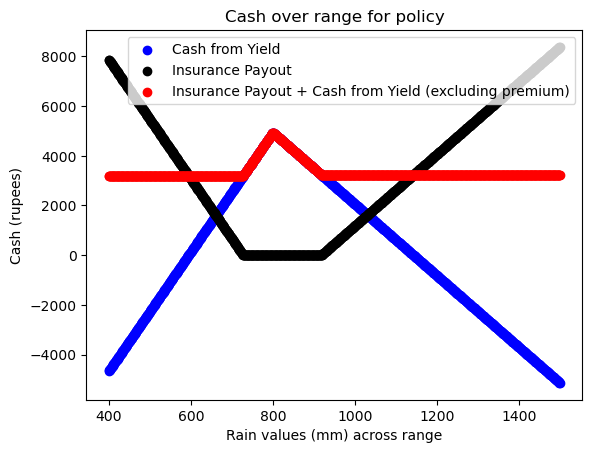

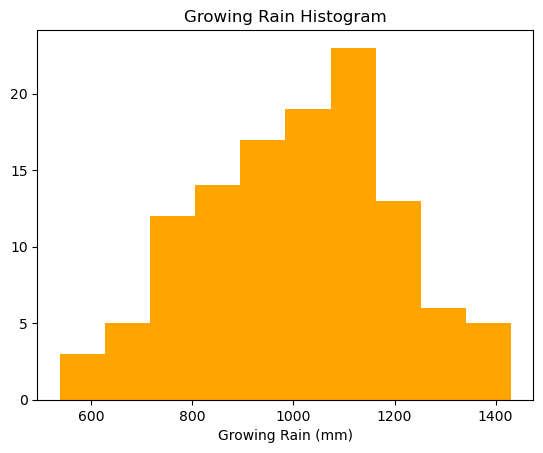

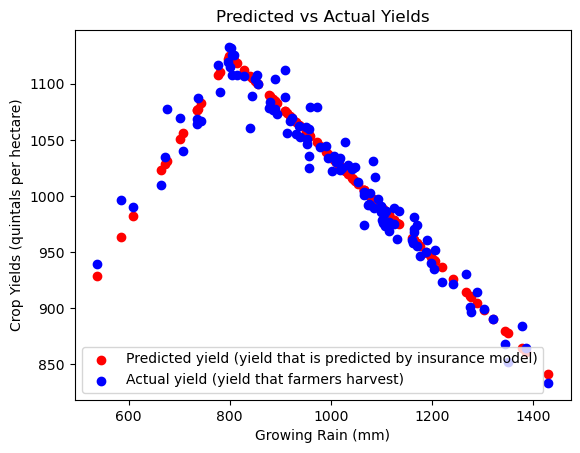

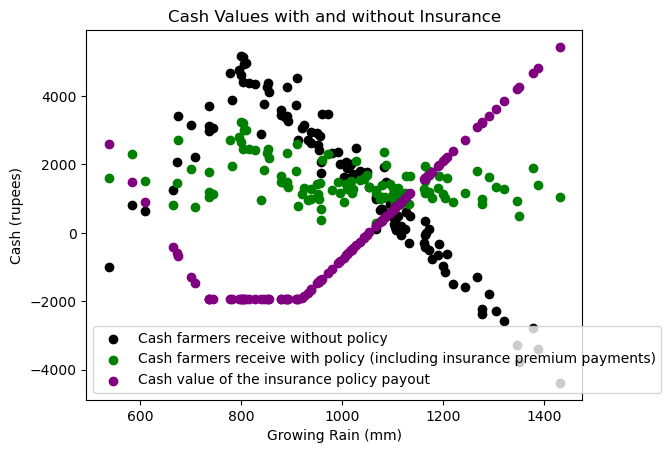

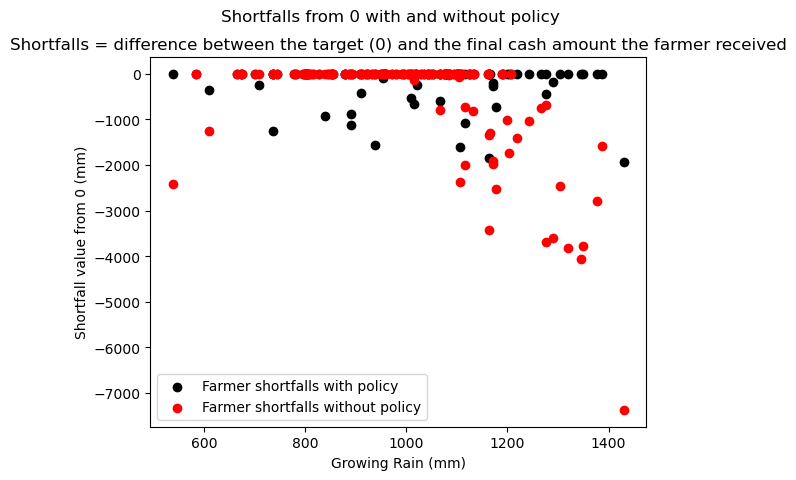

In [215]:
def full_sim(rain_to_yield, 
              lower_threshold = 800, 
              upper_threshold = 800.5, 
              lower_shift = 0, 
              upper_shift = 0,
              n_trials = 10,
              n_years = 2, 
              yield_variability = 50,
              shortfall_target = 0,
              empirical = True, 
              only_positive = True,
              sorted = False,
              muted = False,
              custom_rain_to_insurance = None,
              seed = 0):
    
    # set up insurance policy
    rain_to_insurance = None
    if only_positive:
        rain_to_insurance = insurance_only_positive_yields(rain_to_yield, lower_threshold, upper_threshold, lower_shift, upper_shift)
    else:
        rain_to_insurance = insurance_neg_yields(rain_to_yield, lower_threshold, upper_threshold)
    if custom_rain_to_insurance != None:
        rain_to_insurance = custom_rain_to_insurance
    # calcluate insurance values and premium
    premium = premium_calculator(rain_to_insurance)[0]
    print(f"Insurance Premium: {math.trunc(premium)}")
    


    # run simulation based on empirical or random
    sim_out = None
    if empirical: 
        sim_out = insurance_sim_rain_empirical(
            n_trials = n_trials, 
            yield_simulator = YieldSimulator(rain_to_yield), 
            yield_to_cash = yield_to_cash_func,
            insurance_policy= rain_to_insurance,
            yield_variability= yield_variability,
            premium = premium,
            seed = seed,
            target = shortfall_target
                )
    else:
        sim_out = insurance_sim_rain_sample(
            n_trials = n_trials, 
            n_years = n_years, 
            yield_simulator = YieldSimulator(rain_to_yield), 
            yield_to_cash = yield_to_cash_func,
            insurance_policy= rain_to_insurance,
            yield_variability= yield_variability,
            premium = premium,
            seed = seed,
            target = shortfall_target
                )
    print(f"Expected shortfalls with policy when the target is {shortfall_target}: {math.trunc(np.mean(sim_out[6]))}")
    print(f"Expected shortfalls with NO policy when the target is {shortfall_target}: {math.trunc(np.mean(sim_out[7]))}")
    print(f"Shortfall advantage of policy over no policy {math.trunc(np.mean(sim_out[6]) - np.mean(sim_out[7]))}")
    if muted:

        return sim_out
    # graphs for vsiualization
    # plot yield function and insurance output
    rain_values = np.linspace(400, 1500, 1000)
    plt.scatter(rain_values, yield_to_cash_func(rain_to_yield.return_yield(total_values)), color = 'blue', label = 'Cash from Yield')
    plt.scatter(rain_values, rain_to_insurance(total_values), color = 'black', label = 'Insurance Payout')
    # cash with policy
    list_to_plot = yield_to_cash_func(rain_to_yield.return_yield(total_values)) + rain_to_insurance(total_values)
    plt.scatter(rain_values, list_to_plot, color = 'red', label = 'Insurance Payout + Cash from Yield (excluding premium)')
    # setting matplotlib values
    plt.title(f"Cash over range for policy")
    plt.ylabel("Cash (rupees)")
    plt.xlabel(f"Rain values (mm) across range")
    plt.legend()
    plt.figure()
    # rain histogram (empirical)
    if empirical:
        
        plt.hist(growing_rain_data, bins = 10, color = 'orange')
        plt.title("Growing Rain Histogram")
        plt.xlabel("Growing Rain (mm)")
        plt.figure()

        # predicted vs actual yields
        plt.scatter(growing_rain_data, np.mean(sim_out[1], axis = 0), color = 'red', label = 'Predicted yield (yield that is predicted by insurance model)')
        plt.scatter(growing_rain_data, np.mean(sim_out[2], axis = 0), color = 'blue', label = 'Actual yield (yield that farmers harvest)')
        plt.title("Predicted vs Actual Yields")
        plt.xlabel("Growing Rain (mm)")
        plt.ylabel("Crop Yields (quintals per hectare)")
        plt.legend()
        plt.figure()

        # cash values 

        plt.scatter(growing_rain_data, np.mean(sim_out[3], axis = 0), color = 'black', label = 'Cash farmers receive without policy')
        plt.scatter(growing_rain_data, np.mean(sim_out[4], axis = 0), color = 'green', label = 'Cash farmers receive with policy (including insurance premium payments)')
        plt.scatter(growing_rain_data, np.mean(sim_out[5], axis = 0), color = 'purple', label = 'Cash value of the insurance policy payout')
        plt.title("Cash Values with and without Insurance")
        plt.xlabel("Growing Rain (mm)")
        plt.ylabel("Cash (rupees)")
        plt.legend()
        plt.figure()
        #shortfall calculation and plotting


        plt.scatter(growing_rain_data, sim_out[6], color = 'black', label = 'Farmer shortfalls with policy')
        #print(f"Expected policy shortfalls per year: {sim_out[6]}")
        plt.scatter(growing_rain_data, sim_out[7], color = 'red', label = 'Farmer shortfalls without policy')
        #print(f"Expected no policy shortfalls per year: {sim_out[7]}")
        plt.legend()
        plt.suptitle(f"Shortfalls from {shortfall_target} with and without policy")
        plt.title(f"Shortfalls = difference between the target ({shortfall_target}) and the final cash amount the farmer received")
        plt.xlabel("Growing Rain (mm)")
        plt.ylabel(f"Shortfall value from {shortfall_target} (mm)")
        
        
        

    else:
    # rain histogram (sample)
        plt.plot(np.mean(sim_out[0], axis = 1), color = 'red', label = "Growing period rain (aggregate of rain from half of June, July, August, and September)")
        plt.legend()
        plt.title("Growing rain over the trials")
        plt.xlabel("Growing Rain (mm)")
        plt.figure()
        # predicted vs actual yields
        plt.plot(np.mean(sim_out[1], axis = 1), color = 'red', label = 'Predicted yield (yield that is predicted by insurance model)')
        plt.plot(np.mean(sim_out[2], axis = 1), color = 'blue', label = 'Actual yield (yield that farmers harvest)')
        plt.title("Predicted vs Actual Yields")
        plt.xlabel("Growing Rain (mm)")
        plt.ylabel("Crop Yields (quintals per hectare)")
        plt.legend()
        plt.figure()
        # cash values
        plt.plot(np.mean(sim_out[3], axis = 1), color = 'black', label = 'Cash farmers receive without policy')
        plt.plot(np.mean(sim_out[4], axis = 1), color = 'green', label = 'Cash farmers receive with policy (including insurance premium payments)')
        plt.plot(np.mean(sim_out[5], axis = 1), color = 'purple', label = 'Cash value of the insurance policy payout')
        plt.title("Cash Values with and without Insurance")
        plt.xlabel("Growing Rain (mm)")
        plt.ylabel("Cash (rupees)")
        plt.legend()
        plt.figure()


        #shortfall calculation and plotting

        plt.plot(sim_out[6], color = 'black', label = 'policy shortfalls')
        #print(f"Expected policy shortfalls per year: {sim_out[6]}")
        plt.plot(sim_out[7], color = 'red', label = 'no policy shortfalls')
        #print(f"Expected no policy shortfalls per year: {sim_out[7]}")
        plt.legend()

        








    #print(sim_out[1].shape)
    #noise_std = np.std(sim_out[1] - sim_out[2])
    #print("Noise_STD = " + str(noise_std))
    # std_dev_cash_with_policy = np.std(sim_out[4])
    # print("Cash w/ insurance standard deviation = " + str(std_dev_cash_with_policy))
    # print("Ratio of cash std / prediction std = " + str(std_dev_cash_with_policy / noise_std))
    
    # plot sim output
    


    
    

    
    


    #plotting across years 

full_sim(     rain_to_yield = growing_rain_yield_functions[4], 
              lower_shift = 100,
              upper_shift = -225,
              yield_variability = 50,
              shortfall_target = 0,
              seed = 13)
    





# step function

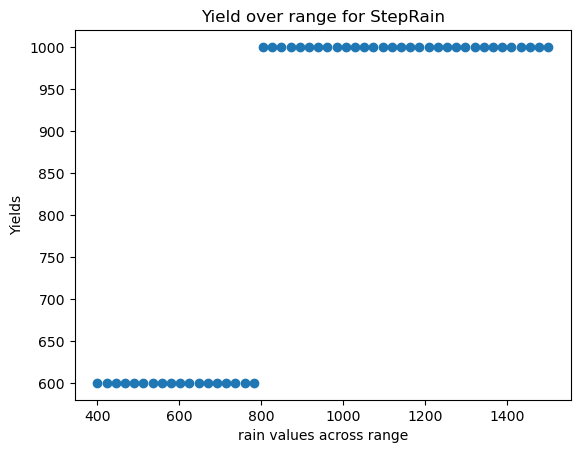

In [200]:
def step_grow_rain(sum_rain):
    alpha = 800
    return np.piecewise(sum_rain, [sum_rain < alpha, sum_rain >= alpha], [600, 1000])
step_rain = YieldFunction(name = "StepRain", mode = "rain", function = step_grow_rain, num_args = 1, range = [400,1500])
step_rain.plot_function()

# 1 Step, Absolute

Insurance Premium: 1590
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is 0: -995
Expected shortfalls with NO policy when the target is 0: -486
Shortfall advantage of policy over no policy -508


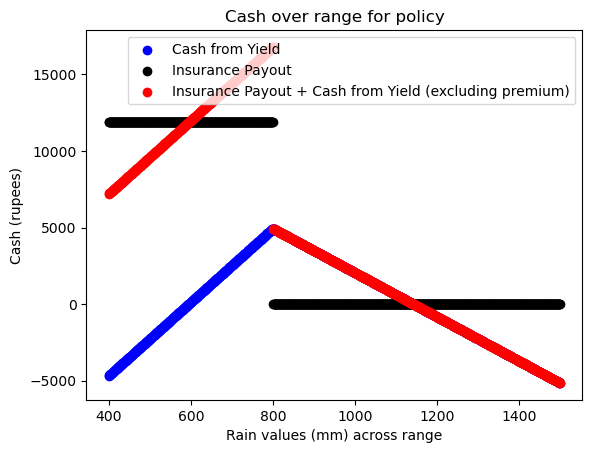

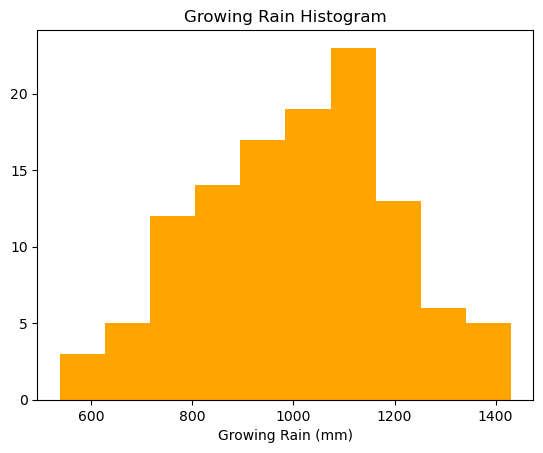

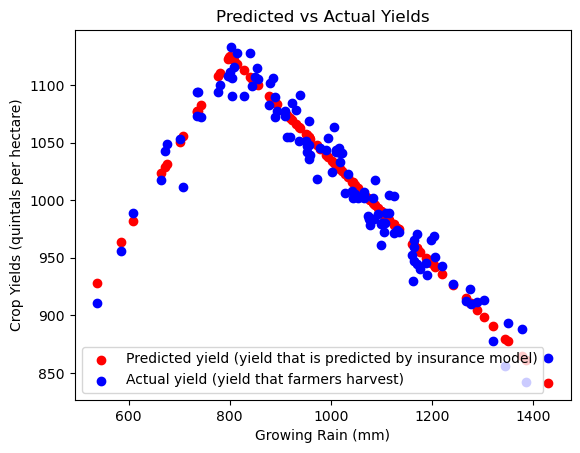

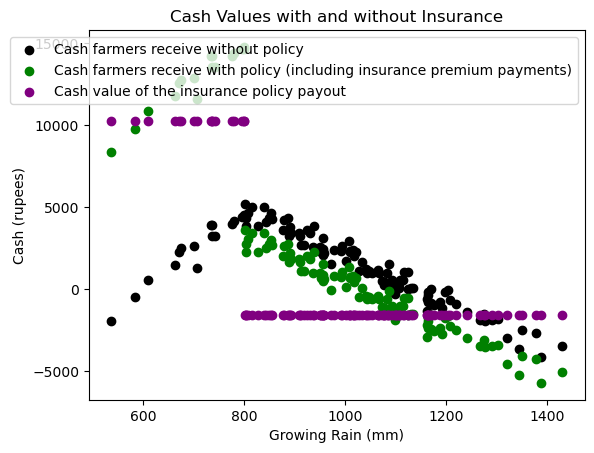

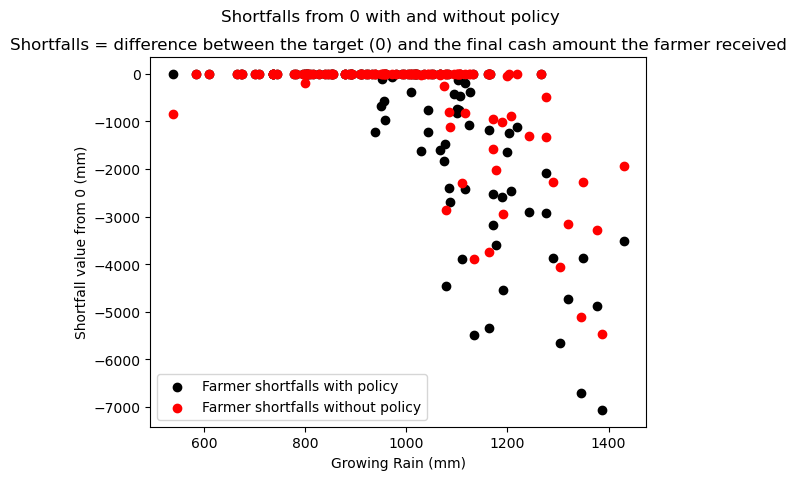

In [220]:
full_sim(     rain_to_yield = abs_rain, 
              custom_rain_to_insurance = insurance_only_positive_yields(step_rain, 800, 800.5, 0, 0))

# 1.5 Step, Step
this one shows that there's still a big advantage to the policy over no policy (but underlying rain to yield being a step function seems unlikely)


Insurance Premium: 1590
Name of Yield Function: StepRain
Expected shortfalls with policy when the target is 0: -1033
Expected shortfalls with NO policy when the target is 0: -1956
Shortfall advantage of policy over no policy 922


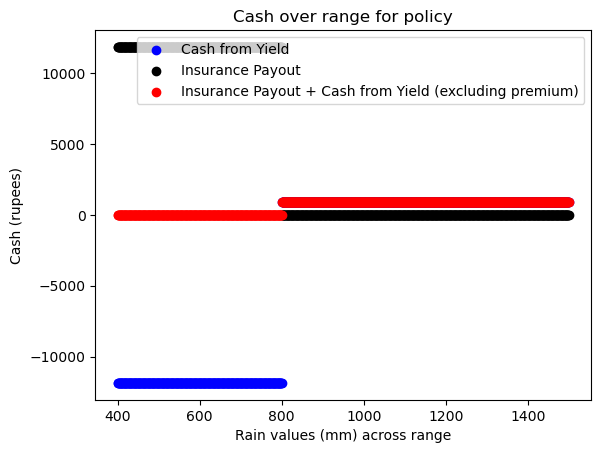

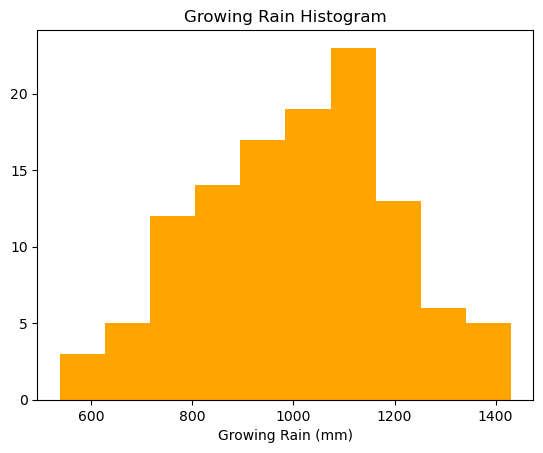

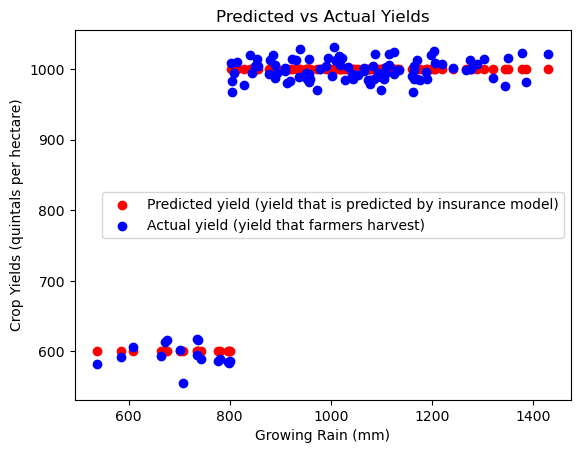

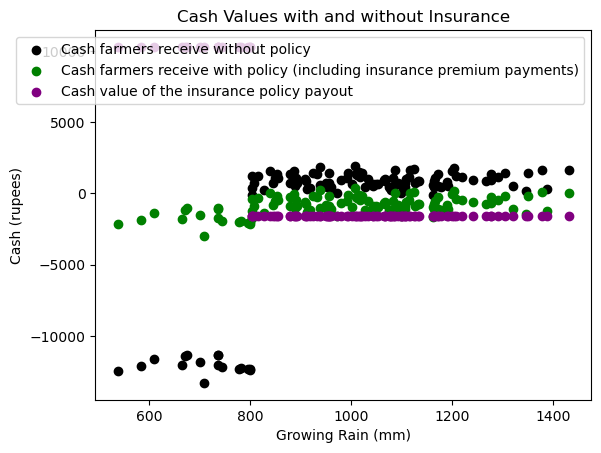

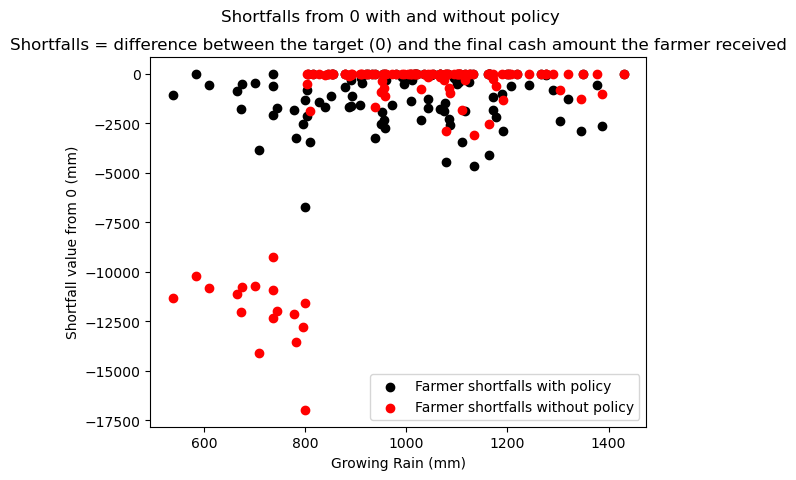

In [221]:
full_sim(     rain_to_yield = step_rain)

Insurance Premium: 373
Name of Yield Function: StepRain
Expected shortfalls with policy when the target is 0: -2042
Expected shortfalls with NO policy when the target is 0: -1956
Shortfall advantage of policy over no policy -86


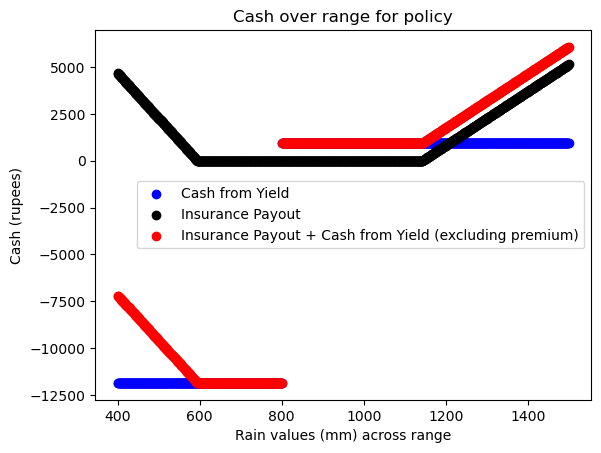

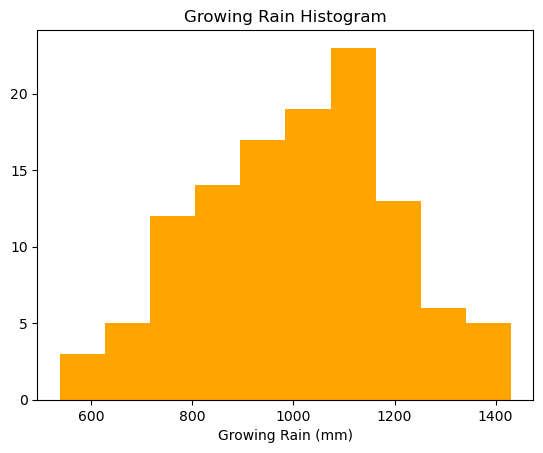

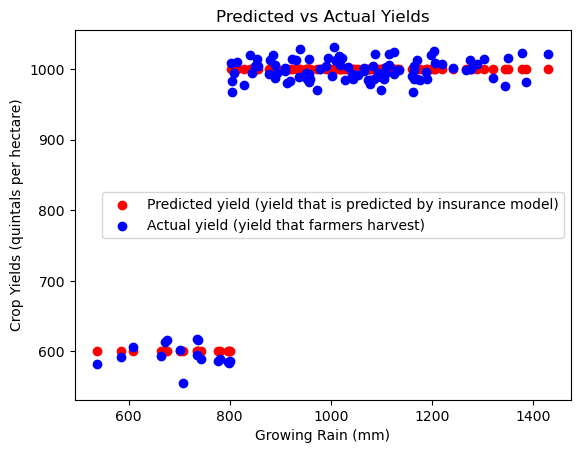

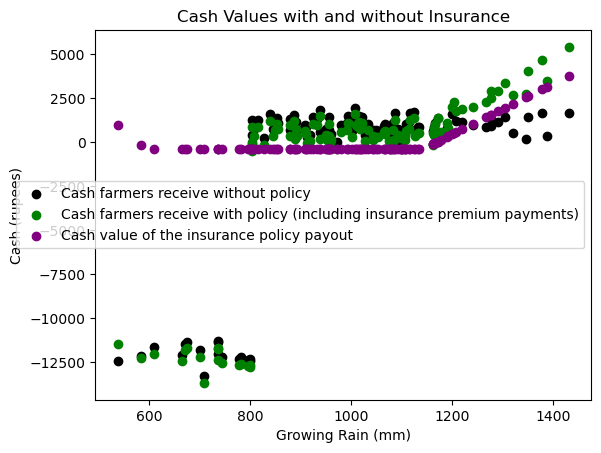

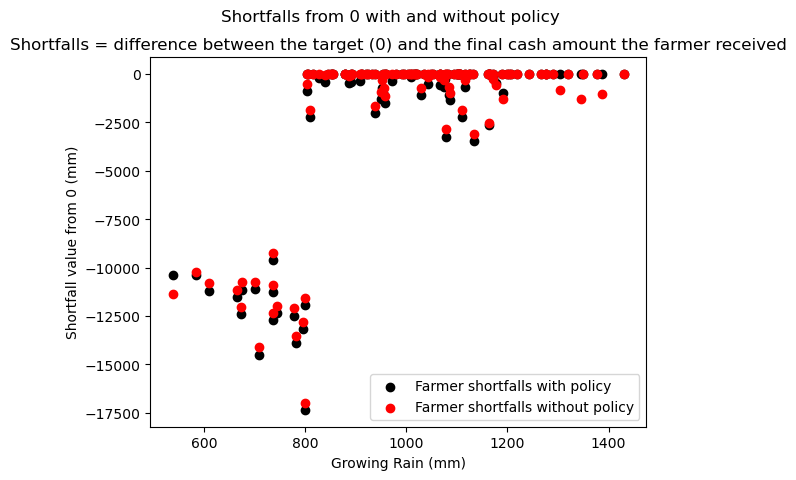

In [224]:
full_sim(     rain_to_yield = step_rain,
               custom_rain_to_insurance = insurance_only_positive_yields(abs_rain, 800, 800.5, 0, 0))

# 2 One Sided Linear, Absolute

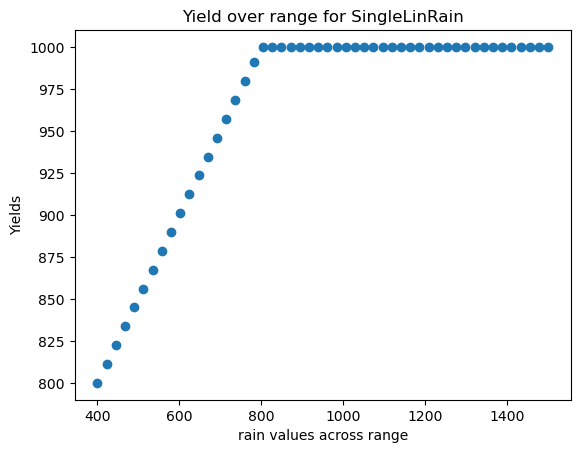

In [202]:
def one_side_linear(sum_rain):
    alpha = 0.5 
    threshold = 800
    # if sum_rain >= 800:
    #     return 1000
    # else:
    #     return 1000 - alpha * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain < threshold, sum_rain >= threshold], [lambda x: 1000 - alpha * (threshold - x), 1000])
one_lin_yield = YieldFunction(name = "SingleLinRain", mode = "rain", function = one_side_linear, num_args = 1, range = [400,1500])
one_lin_yield.plot_function()


Insurance Premium: 103
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is 0: -505
Expected shortfalls with NO policy when the target is 0: -486
Shortfall advantage of policy over no policy -18


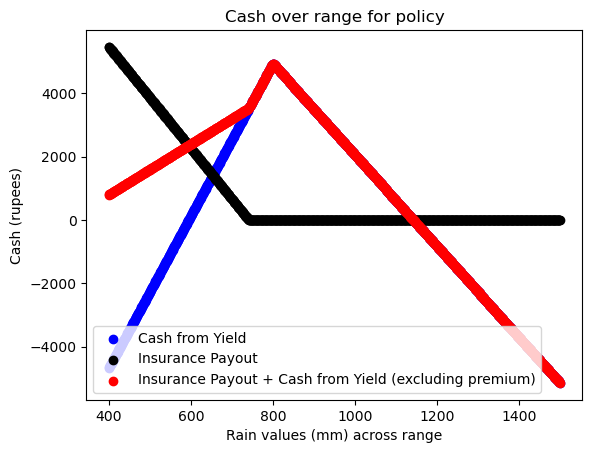

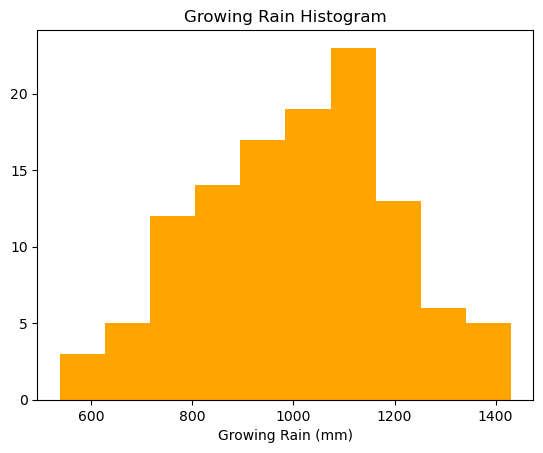

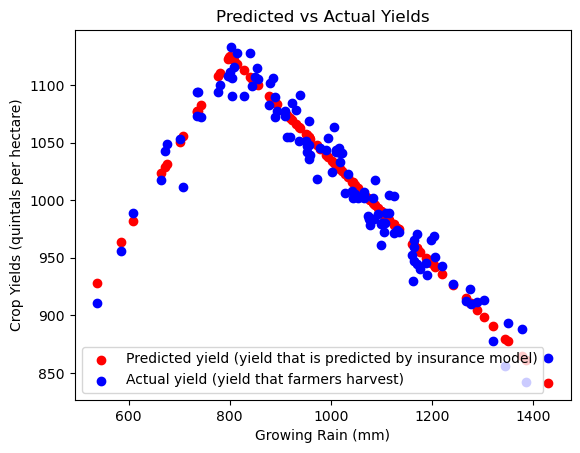

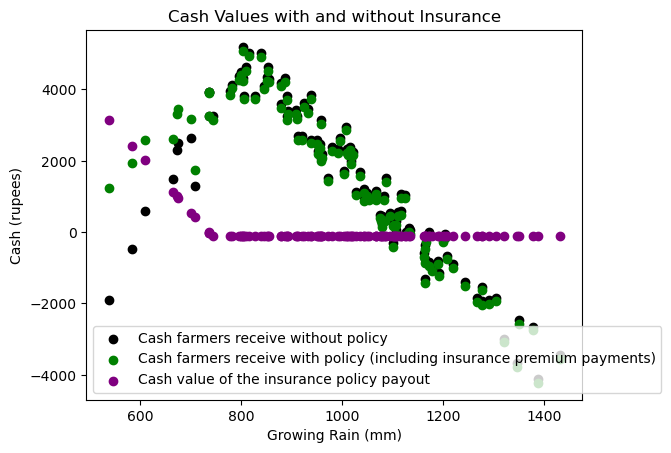

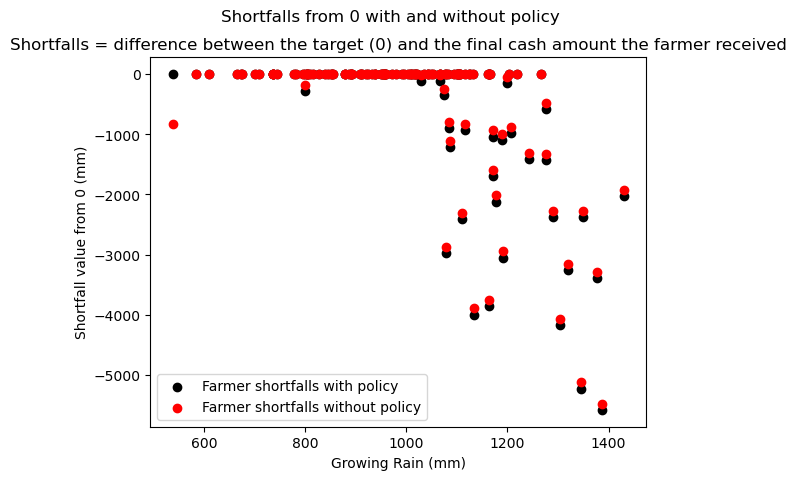

In [226]:
full_sim(     rain_to_yield = abs_rain, 
              custom_rain_to_insurance = insurance_only_positive_yields(one_lin_yield, 800, 800.5, 0, 0))

# 2.5 one-sided linear, one-sided linear 
also another case where the policy is better than without (if the underlying is a one-sided linear)

Insurance Premium: 103
Name of Yield Function: SingleLinRain
Expected shortfalls with policy when the target is 0: -326
Expected shortfalls with NO policy when the target is 0: -354
Shortfall advantage of policy over no policy 27


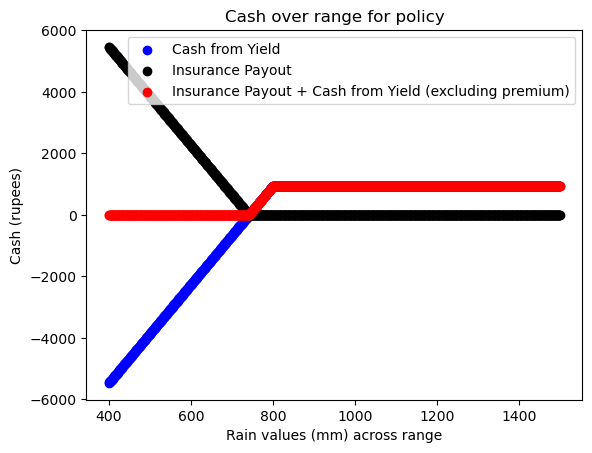

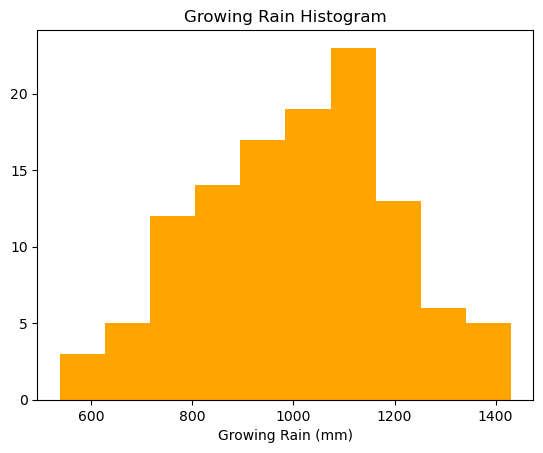

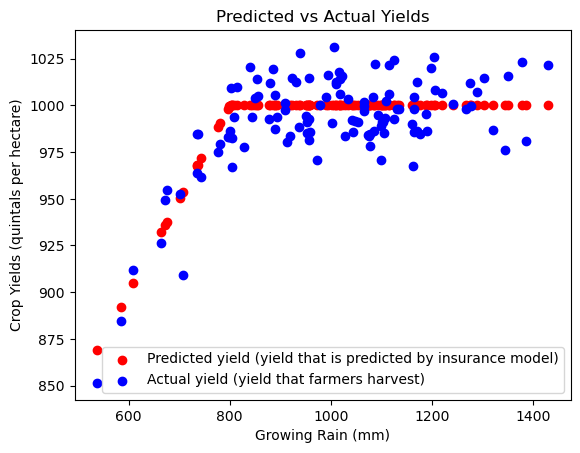

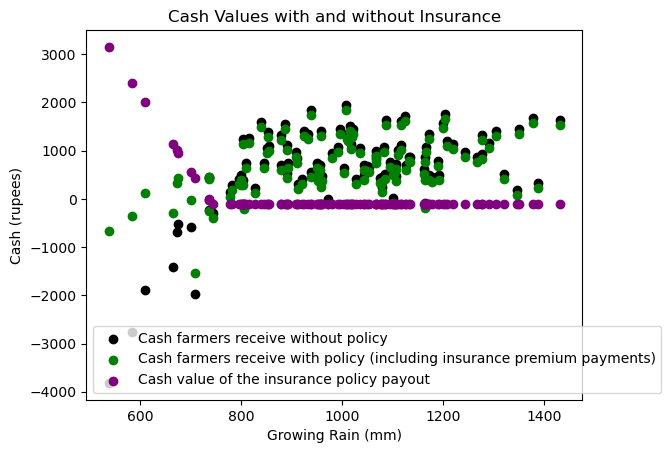

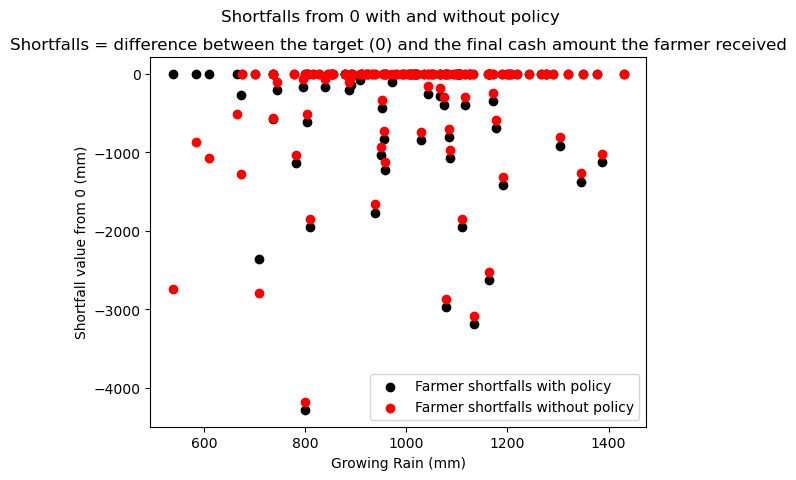

In [225]:
full_sim(one_lin_yield)

# 3 Absolute, Absolute (full mirror)

Insurance Premium: 373
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is 0: -318
Expected shortfalls with NO policy when the target is 0: -486
Shortfall advantage of policy over no policy 168


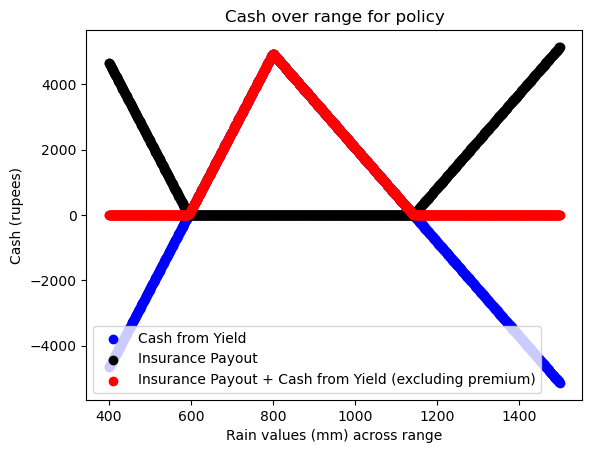

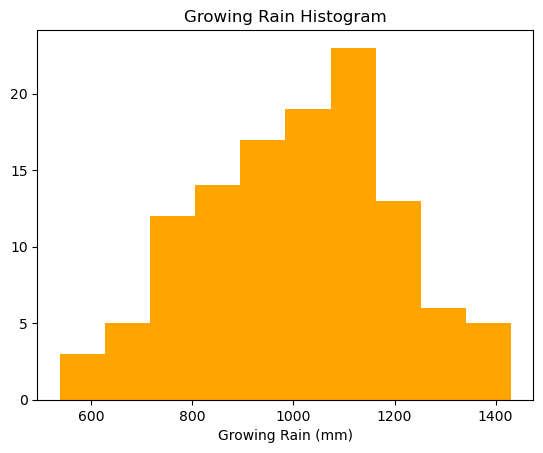

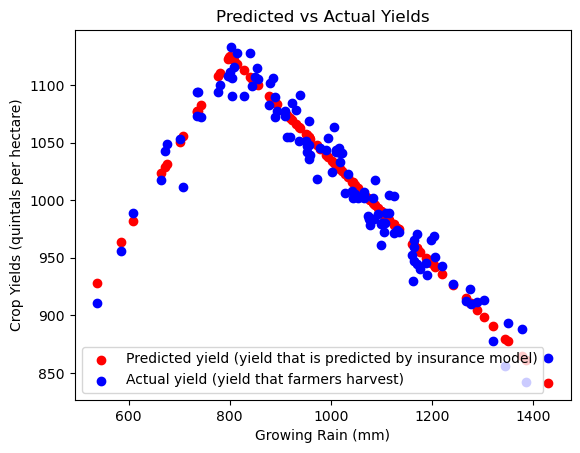

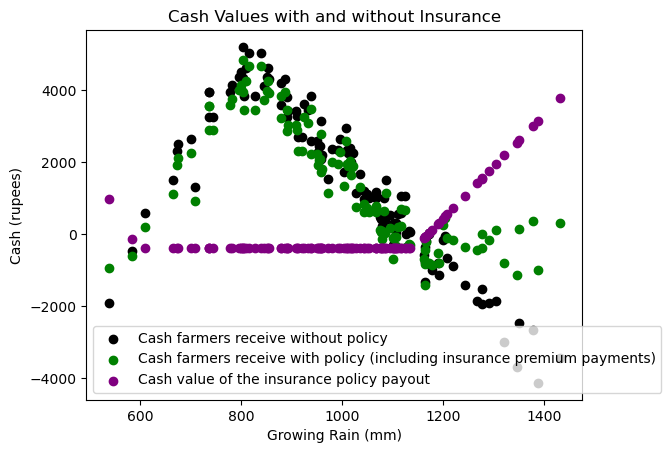

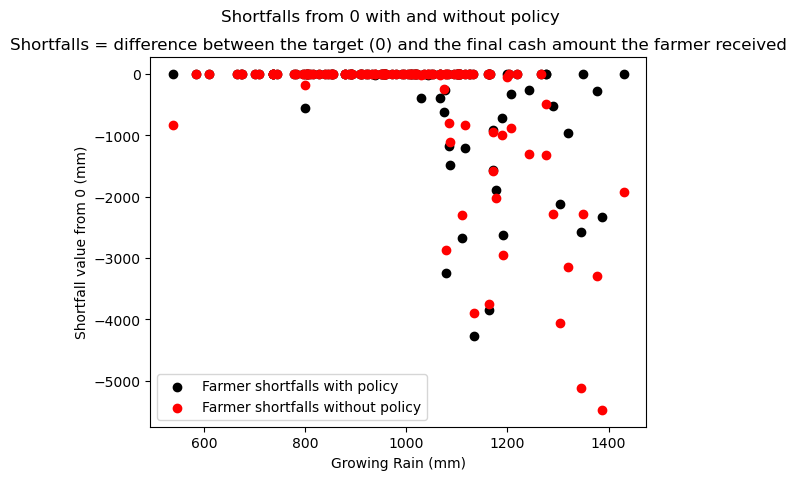

In [227]:
full_sim(     rain_to_yield = abs_rain, 
              custom_rain_to_insurance = insurance_only_positive_yields(abs_rain, 800, 800.5, 0, 0))

# 4 Absolute, non-full mirror 

Insurance Premium: 2194
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is 0: -157
Expected shortfalls with NO policy when the target is 0: -486
Shortfall advantage of policy over no policy 328


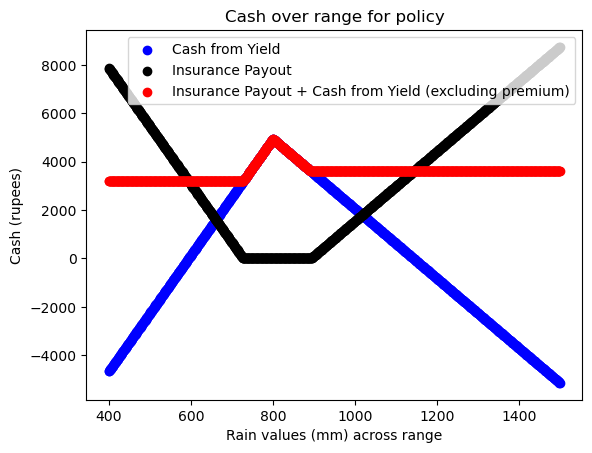

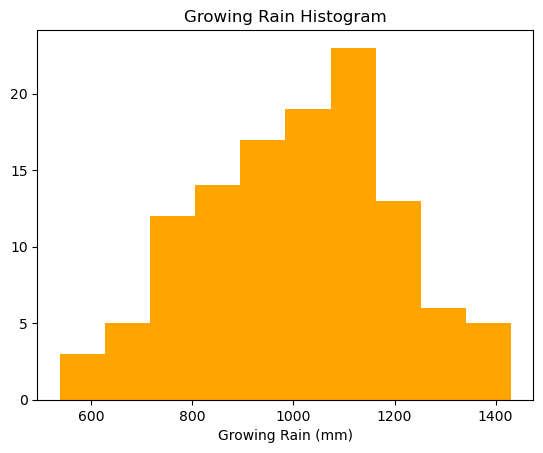

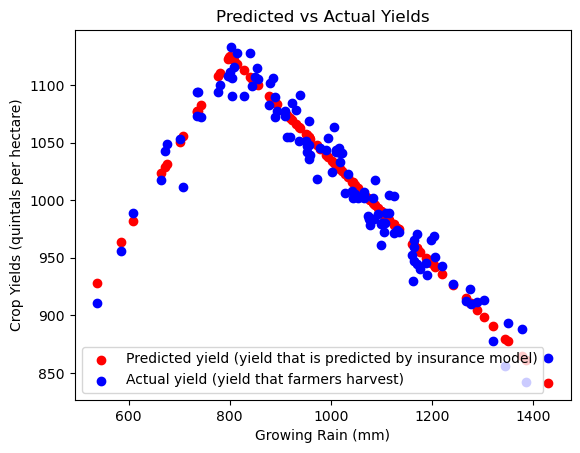

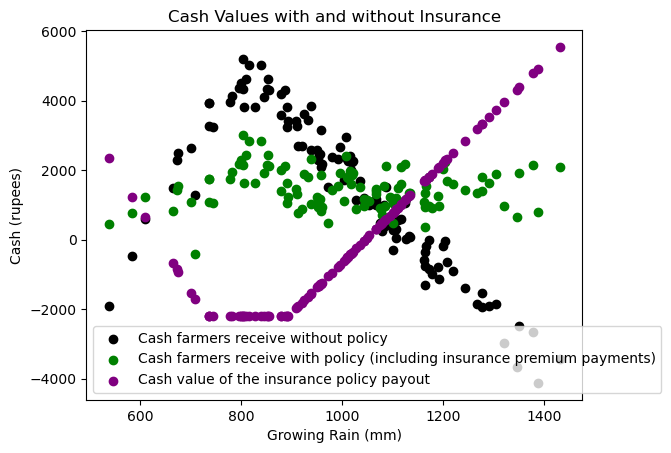

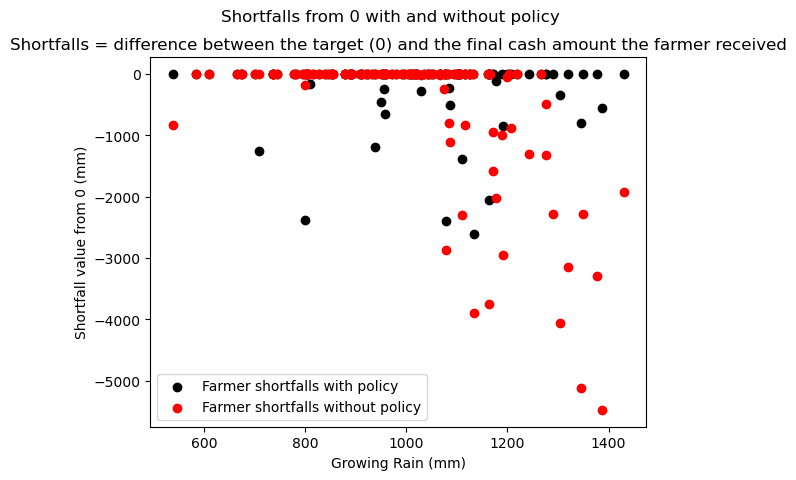

In [234]:

sim_out = full_sim(     rain_to_yield = abs_rain, 
              lower_shift = 100,
              upper_shift = -250
              )


# Parameter Sweep on Shortfall Targets and Variabilities

In [218]:
## double parameter sweep 
## random sample
def ablation_shortfalls(rain_to_yield, 
                        lower_threshold = 800, 
                        upper_threshold = 800.5, 
                        empirical = True, 
                        only_positive = True, 
                        sorted = True, 
                        muted = True):
    policy_shortfalls = []
    no_policy_shortfalls = []
    tuples_parameter_list = []
    target_sweep = np.linspace(-1000, 0, 5)
    variability_sweep = np.linspace(50, 300, 6)
    for target in target_sweep:
        for variability in variability_sweep:

            tuples_parameter_list.append((target, variability))
        
            x = full_sim(     rain_to_yield = rain_to_yield, 
                lower_threshold = lower_threshold, 
                upper_threshold = upper_threshold, 
                n_trials = 1000,
                n_years = 2,
                yield_variability = variability,
                shortfall_target = target,
                empirical = empirical,
                only_positive = only_positive,
                sorted = sorted,
                muted = muted)
            policy_shortfalls.append(np.mean(x[6]))
            no_policy_shortfalls.append(np.mean(x[7]))
    plot_shortfalls_ablation(policy_shortfalls, no_policy_shortfalls)
#print(f"Policy shortfalls across the shortfall target values: {policy_shortfalls}")
#print(f"Policy shortfalls across the shortfall target values: {no_policy_shortfalls}")
def plot_shortfalls_ablation(policy_shortfalls, no_policy_shortfalls):
    plt.figure()
    plt.plot(policy_shortfalls, color = 'black', label = 'policy_shortfalls')
    plt.plot(no_policy_shortfalls, color = 'red', label = 'no_policy_shortfalls')
    plt.legend()
    arr_no_policy_shortfalls = np.trunc(np.array(policy_shortfalls).reshape(-1,1))
    arr_policy_shortfalls = np.trunc(np.array(no_policy_shortfalls).reshape(-1,1))
    arr_tuples = np.array(tuples_parameter_list)
    arr_policy_advantage = arr_policy_shortfalls - arr_no_policy_shortfalls
    concatenated = np.concatenate((arr_tuples, arr_no_policy_shortfalls, arr_policy_shortfalls, arr_policy_advantage), axis = 1)
    print(concatenated.shape)
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    df = pd.DataFrame(concatenated, columns=['shortfall targets',
                                            'variability values',
                                            'no policy shortfalls', 
                                            'policy shortfalls',
                                            'policy advantage over no policy'])

    ax.table(cellText=df.values, colWidths = [0.5, 0.5, 0.5, 0.5, 0.5], colLabels=df.columns, loc='center')

    plt.title(label = "parameter sweep across shortfall target values (floats truncated to integers)", color = "white")

    plt.show()

Insurance Premium: 373
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -189
Expected shortfalls with NO policy when the target is -1000.0: -350
Shortfall advantage of policy over no policy 161
Insurance Premium: 373
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -618
Expected shortfalls with NO policy when the target is -1000.0: -714
Shortfall advantage of policy over no policy 96
Insurance Premium: 373
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -1196
Expected shortfalls with NO policy when the target is -1000.0: -1244
Shortfall advantage of policy over no policy 47
Insurance Premium: 373
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -1848
Expected shortfalls with NO policy when the target is -1000.0: -1877
Shortfall advantage of policy over no policy 29
Insurance Premium: 373
Name of Yield Function: AbsR

NameError: name 'tuples_parameter_list' is not defined

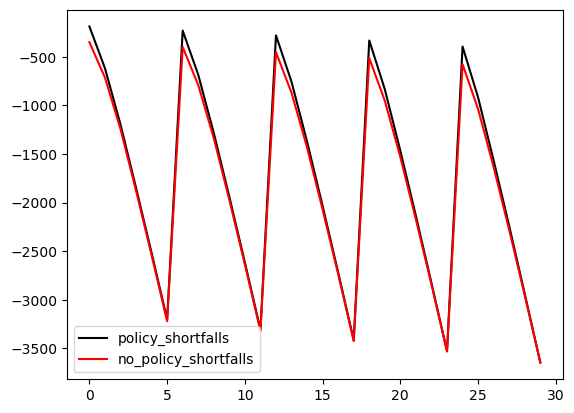

In [219]:
ablation_shortfalls(rain_to_yield = growing_rain_yield_functions[4], 
                    )

Insurance Premium: -4114.0708603055955
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: 0.0
Expected shortfalls with NO policy when the target is -1000.0: -14.703436824238295
Insurance Premium: -4109.058003777886
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -81.68448725750574
Expected shortfalls with NO policy when the target is -1000.0: -95.90966991622395
Insurance Premium: -4107.703988242965
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -220.03407181725106
Expected shortfalls with NO policy when the target is -1000.0: -253.9912985608501
Insurance Premium: -4109.531461488465
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -897.6575808972518
Expected shortfalls with NO policy when the target is -1000.0: -901.6699916120177
Insurance Premium: -4107.669634298439
Name of Yield Function: AbsRain
Expected shortfall

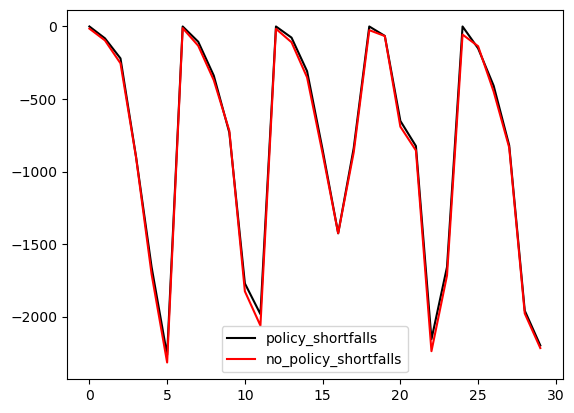

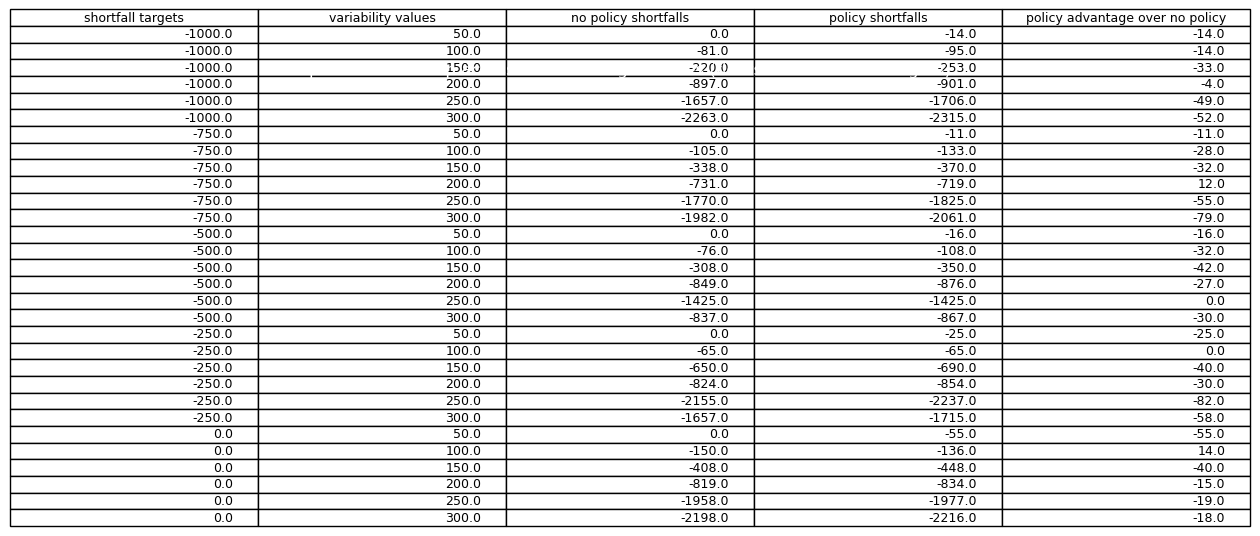

In [ ]:
ablation_shortfalls(rain_to_yield = growing_rain_yield_functions[4], 
                    lower_threshold = 799, 
                    upper_threhsold = 800, 
                    empirical = True, 
                    only_positive = False, 
                    sorted = True, 
                    muted = True)

Insurance Premium: -4114.431479072514
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: 0.0
Expected shortfalls with NO policy when the target is -1000.0: 0.0
Insurance Premium: -4105.430754667421
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: 0.0
Expected shortfalls with NO policy when the target is -1000.0: -571.2861760446885
Insurance Premium: -4103.900613338238
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: 0.0
Expected shortfalls with NO policy when the target is -1000.0: 0.0
Insurance Premium: -4115.919021282604
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -1851.2047472225727
Expected shortfalls with NO policy when the target is -1000.0: -1595.6988442722413
Insurance Premium: -4106.921896062091
Name of Yield Function: AbsRain
Expected shortfalls with policy when the target is -1000.0: -219.63992741406673

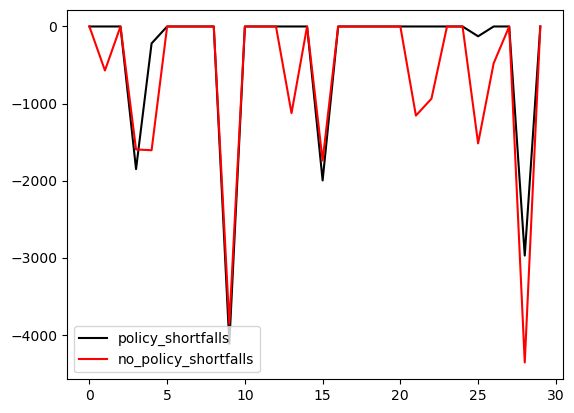

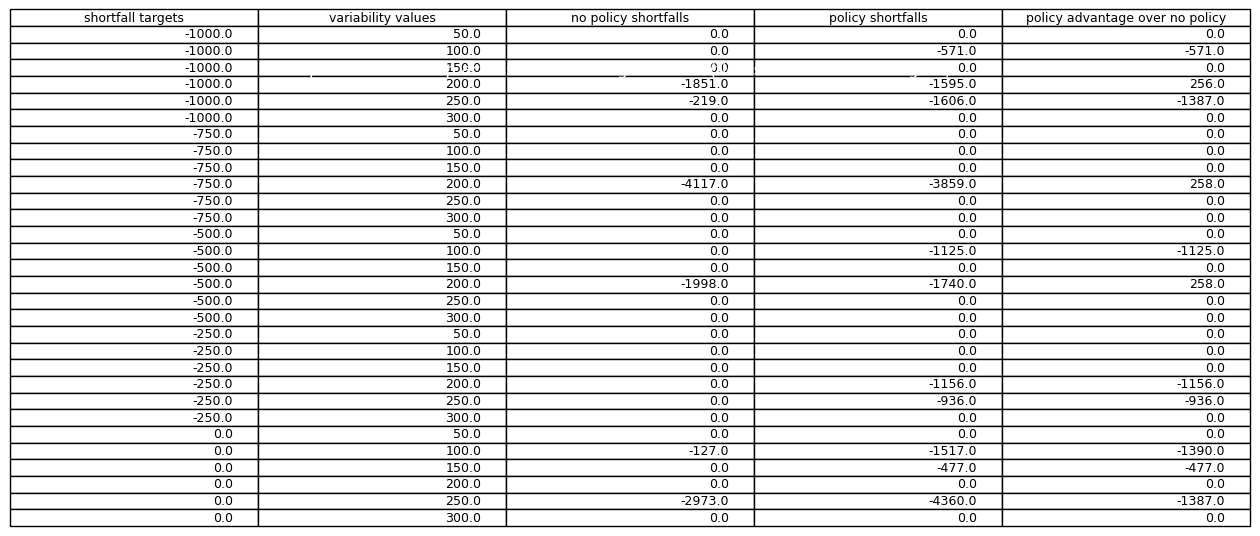

In [ ]:
ablation_shortfalls(rain_to_yield = growing_rain_yield_functions[4], 
                    lower_threshold = 799, 
                    upper_threhsold = 800, 
                    empirical = False, 
                    only_positive = False, 
                    sorted = True, 
                    muted = True)

In [ ]:
def abs_grow_rain1(sum_rain):
    alpha = 0.75
    beta = 0.10
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1125 - alpha * (800 - x), lambda x: 1125 + beta * alpha * (800 - x)])
def abs_grow_rain2(sum_rain):
    alpha = 0.75
    beta = 0.25
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1125 - alpha * (800 - x), lambda x: 1125 + beta * alpha * (800 - x)])
def abs_grow_rain3(sum_rain):
    alpha = 0.75
    beta = 0.50
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1125 - alpha * (800 - x), lambda x: 1125 + beta * alpha * (800 - x)])

In [ ]:
a = YieldFunction(name = "AbsRain1", mode = "rain", function = abs_grow_rain1, num_args = 1, range = [0,1500])
b = YieldFunction(name = "AbsRain2", mode = "rain", function = abs_grow_rain2, num_args = 1, range = [0,1500])
c = YieldFunction(name = "AbsRain3", mode = "rain", function = abs_grow_rain3, num_args = 1, range = [0,1500])

Insurance Premium: 18.461539246755137
Name of Yield Function: AbsRain1
Expected shortfalls with policy when the target is -1000.0: 0.0
Expected shortfalls with NO policy when the target is -1000.0: 0.0
Insurance Premium: 19.67493198376685
Name of Yield Function: AbsRain1
Expected shortfalls with policy when the target is -1000.0: -71.76207010838479
Expected shortfalls with NO policy when the target is -1000.0: -84.15741605807392
Insurance Premium: 21.205775260863245
Name of Yield Function: AbsRain1
Expected shortfalls with policy when the target is -1000.0: -386.4331718137489
Expected shortfalls with NO policy when the target is -1000.0: -384.97038130941087
Insurance Premium: 21.174721111195353
Name of Yield Function: AbsRain1
Expected shortfalls with policy when the target is -1000.0: -951.3561486617873
Expected shortfalls with NO policy when the target is -1000.0: -946.8316356038397
Insurance Premium: 20.02677649906957
Name of Yield Function: AbsRain1
Expected shortfalls with policy 

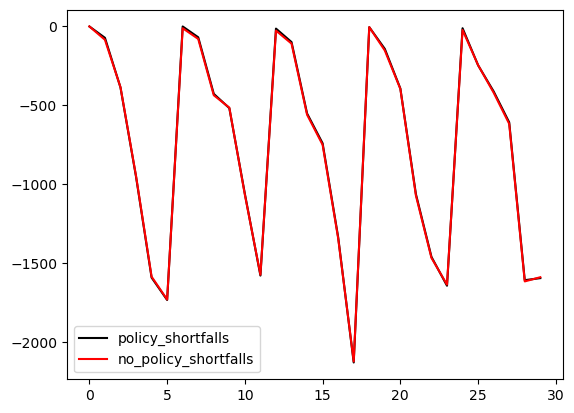

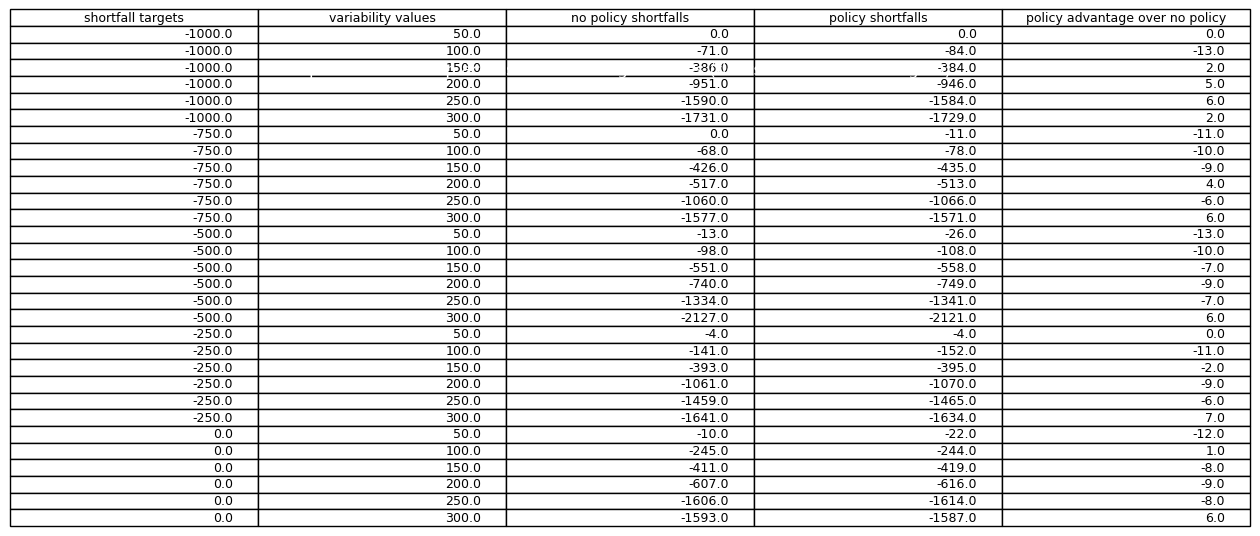

Insurance Premium: 20.878482760188874
Name of Yield Function: AbsRain2
Expected shortfalls with policy when the target is -1000.0: 0.0
Expected shortfalls with NO policy when the target is -1000.0: -6.777968100814955
Insurance Premium: 21.586050721216722
Name of Yield Function: AbsRain2
Expected shortfalls with policy when the target is -1000.0: -118.75426674058824
Expected shortfalls with NO policy when the target is -1000.0: -121.08647941673111
Insurance Premium: 19.43077652085384
Name of Yield Function: AbsRain2
Expected shortfalls with policy when the target is -1000.0: -430.7423237352504
Expected shortfalls with NO policy when the target is -1000.0: -430.4291538951482
Insurance Premium: 19.980212079463556
Name of Yield Function: AbsRain2
Expected shortfalls with policy when the target is -1000.0: -1400.304032264908
Expected shortfalls with NO policy when the target is -1000.0: -1397.1927813043617
Insurance Premium: 20.57394916826065
Name of Yield Function: AbsRain2
Expected shortf

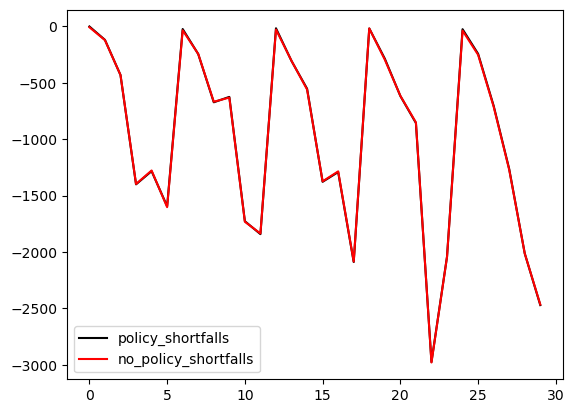

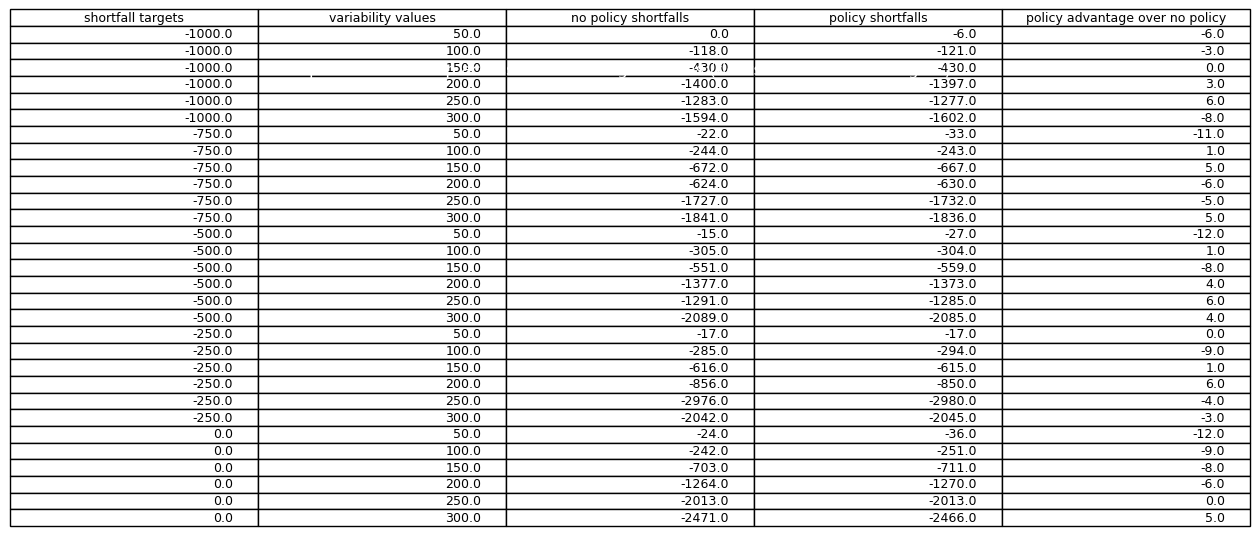

Insurance Premium: 168.61142289487117
Name of Yield Function: AbsRain3
Expected shortfalls with policy when the target is -1000.0: -111.80004548538932
Expected shortfalls with NO policy when the target is -1000.0: -140.98094674542133
Insurance Premium: 168.74060532097542
Name of Yield Function: AbsRain3
Expected shortfalls with policy when the target is -1000.0: -475.1430490319153
Expected shortfalls with NO policy when the target is -1000.0: -513.8987763556861
Insurance Premium: 166.73738131126757
Name of Yield Function: AbsRain3
Expected shortfalls with policy when the target is -1000.0: -611.538248663999
Expected shortfalls with NO policy when the target is -1000.0: -654.5304029307005
Insurance Premium: 167.40900523008207
Name of Yield Function: AbsRain3
Expected shortfalls with policy when the target is -1000.0: -1791.0271722410052
Expected shortfalls with NO policy when the target is -1000.0: -1832.2884553923075
Insurance Premium: 169.71948371630498
Name of Yield Function: AbsRain

KeyboardInterrupt: 

In [ ]:
ablation_shortfalls(rain_to_yield = a, 
                    lower_threshold = 799, 
                    upper_threhsold = 800, 
                    empirical = True, 
                    only_positive = True, 
                    sorted = True, 
                    muted = True)
ablation_shortfalls(rain_to_yield = b, 
                    lower_threshold = 799, 
                    upper_threhsold = 800, 
                    empirical = True, 
                    only_positive = True, 
                    sorted = True, 
                    muted = True)
ablation_shortfalls(rain_to_yield = c, 
                    lower_threshold = 799, 
                    upper_threhsold = 800, 
                    empirical = True, 
                    only_positive = True, 
                    sorted = True, 
                    muted = True)